# Market Microstructure Coursework

## Numerical Study

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import jit
from tqdm import tqdm
from scipy.stats import norm
mpl.rcParams["figure.dpi"] = 480
mpl.rcParams["figure.figsize"] = (10, 6)
plt.style.use("ggplot")
rng = np.random.default_rng()

In discretization, the SDE in the context of GBM can be approximated as:
$$S_{t+\Delta t}=S_t\exp\left(\left(\mu-\frac12\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z_t\right)$$

In [2]:
# this function returns the efficient price
# here we generate several paths then take average when calculating hedging error
def path(num_of_path, num_of_interval, x0=100, vol=0.01, drift=0, T=1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = T / num_of_interval
    z = np.random.normal(size=(num_of_path, num_of_interval))
    w = z * np.sqrt(dt) * vol
    path = np.zeros(shape=(num_of_path, num_of_interval + 1))
    path[:, 0] = np.log(x0)
    path[:, 1:] = (drift - 0.5 * vol**2) * dt + w
    path = np.cumsum(path, axis=1)
    return np.exp(path)

In [3]:
# this function returns the eff price after filtered by the UCM
@jit(nopython = True)
def uncertainty_zone(asset, eta=0.05, tick=0.025, num_of_tick=1):
    # initialise
    n = asset.shape[1] 
    dt = 1 / (n - 1) # size of intervals
    tau = 1 + np.zeros_like(asset) # exit times from the uncertainty zones
    tau[:, 0] = 0
    x = np.zeros_like(asset) # efficient prices
    x[:, 0] = asset[:, 0]
    x_tau = np.zeros_like(asset) # prices at the exit times
    x_tau[:, 0] = asset[:, 0]
    NR = np.zeros(asset.shape[0]) # number of rebalancing
    # for each path
    for k, a in enumerate(asset): 
        prev = a[0] # record the efficient prices before exit from the uncertainty zones
        x[k, 0] = tick * round(prev / tick) # round initial value to the nearest multiple of tick alpha
        # for each time t
        for i, p in enumerate(a[1:], 1):
            # barrier to reach to cause a change in efficient prices
            lower = tick * round(prev / tick) - (1/2 + eta) * tick - (num_of_tick - 1) * tick
            upper = tick * round(prev / tick) + (1/2 + eta) * tick + (num_of_tick - 1) * tick
            # if the barrier is not reached do nothing
            if p <= upper and p >= lower:
                x[k, i] = x[k, i - 1]
                x_tau[k, i] = x_tau[k, i - 1]
            # if the upper barrier is reached then update efficient price and prices at the exit time
            elif p > upper:
                x[k, i] = x[k, i - 1] + tick * num_of_tick
                x_tau[k, i] = x[k, i] - tick * (1/2 - eta)
                prev = x[k, i]
            # if the lower barrier is reached then update efficient price and prices at the exit time
            else:
                x[k, i] = x[k, i - 1] - tick * num_of_tick
                x_tau[k, i] = x[k, i] + tick * (1/2 - eta)
                prev = x[k, i]
            # if there is a change in efficient prices then update exit time and number of rebalance
            if x[k, i] != x[k, i - 1]:
                tau[k, i] = dt * i
                NR[k] += 1
            # if not do nothing
            else:
                tau[k, i] = tau[k, i - 1]
                
    return x, tau, x_tau, NR

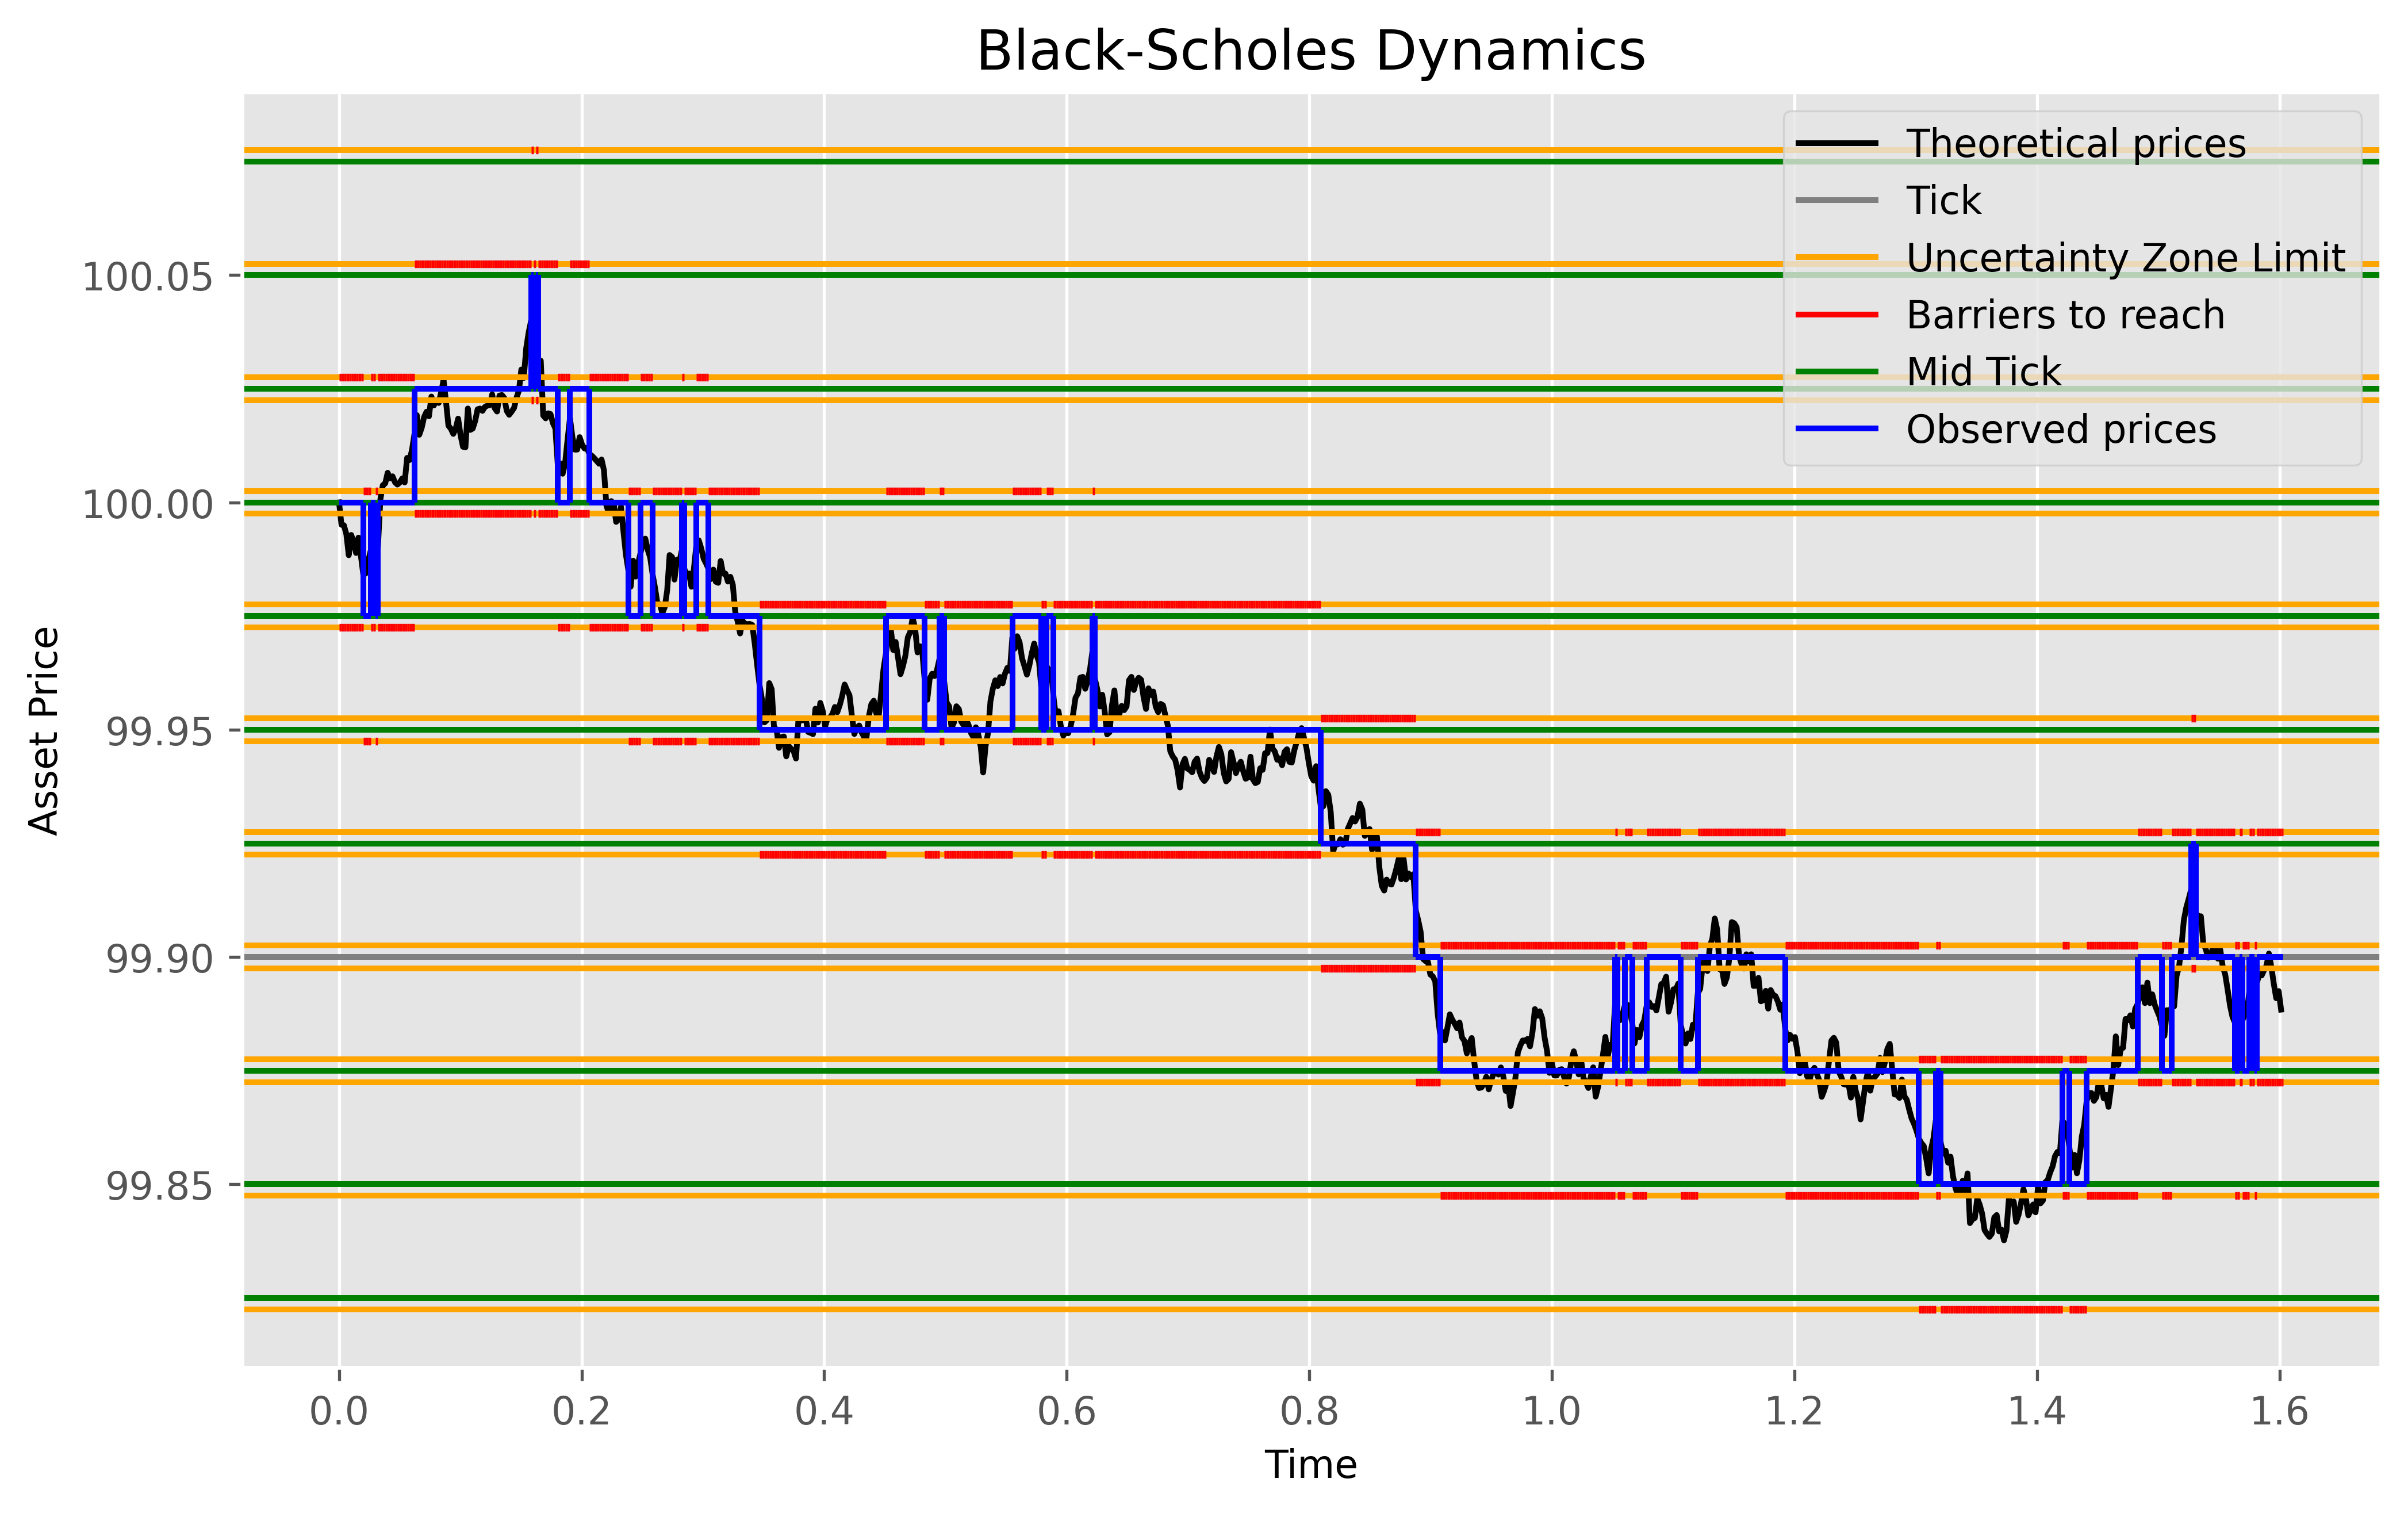

In [4]:

def plot(k, vol=0.01, seed=None):
    eff = path(500, 1000, vol = vol, seed=seed)
    eta = tick = 0.05
    ucm ,tau, x_tau, NR_12_count = uncertainty_zone(eff)
    n = len(tau)
    dt = 1 / (n - 1)
    t = np.array(range(k))
    plt.plot(t*dt, eff[0,0:k], 'k', label = "Theoretical prices")

    for i in range(k):
        plt.axhline(y = ucm[0,i], color = 'grey', linestyle = '-')
        plt.axhline(y = ucm[0,i] - (1/2 + eta) * tick, color = 'orange', linestyle = '-')
        plt.axhline(y = ucm[0,i] + (1/2 + eta) * tick, color = 'orange', linestyle = '-')
        plt.axhline(y = ucm[0,i] - (1/2) * tick, color = 'g', linestyle = '-')
        plt.axhline(y = ucm[0,i] + (1/2) * tick, color = 'g', linestyle = '-')
    for i in range(k):
        plt.hlines(y = ucm[0,i] - (1/2 + eta) * tick, color = 'r', linestyle = '-', xmin = i*dt, xmax = (i+1)*dt, linewidth=2)
        plt.hlines(y = ucm[0,i] + (1/2 + eta) * tick, color = 'r', linestyle = '-', xmin = i*dt, xmax = (i+1)*dt, linewidth=2)
        plt.hlines(y = ucm[0,i], color = 'b', linestyle = '-', xmin = i*dt, xmax = (i+1)*dt)
    for i in range(1,k):
        plt.vlines(x = i*dt, color = 'b', linestyle = '-', ymin = ucm[0,i-1], ymax = ucm[0,i])

    plt.plot([], linestyle='-', color='grey', label='Tick')
    plt.plot([], linestyle='-', color='orange', label='Uncertainty Zone Limit')
    plt.plot([], linestyle='-', color='r', label='Barriers to reach')
    plt.plot([], linestyle='-', color='g', label='Mid Tick')
    plt.plot([], 'b', label='Observed prices')
    plt.title('Black-Scholes Dynamics')
    plt.xlabel('Time')
    plt.ylabel('Asset Price')
    plt.legend()
    plt.grid(True)
    plt.show()

plot(800, vol=0.001, seed=50)

In [5]:
# the function returns the tau as defined in the paper in section 4.1 first line, and the the input shoube be a list of taus
# function takes a time t and an array of exit times tau and return phi(t)
@jit(nopython = True)
def phi(t, tau):
    n = len(tau)
    dt = 1 / (n - 1)
    # find the index of the largest tau such that tau<t
    idx = np.searchsorted(tau, t, side='left')
    if idx == 0:
        return 0
    return (idx - 1) * dt


# function to calculate the derivative of C against x
def C_derivative(x, t=0, r=0, sigma=0.01, K=100, T=1):
    # the derivative is Phi(di) where Phi is the cdf of standard normal
    d1 = (np.log(x / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(
        (T - t)) + 1e-9)
    delta = norm.cdf(d1)
    return delta


# function to compute the matrix of phi(t)
@jit(nopython = True)
def compute_matrix(T, Tau):
    rows = Tau.shape[0]
    cols = len(T[0])
    result = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            result[i, j] = phi(T[0, j], Tau[i, :])
    return result


# function to compute X_{phi(t)}
@jit(nopython = True)
def compute_X_phi(tau, x_tau):
    m, n = tau.shape
    dt = 1 / (n - 1)
    result = np.zeros_like(tau)
    for i in range(m):
        for j in range(n):
            idx = round(tau[i, j] // dt)
            result[i,j] = x_tau[i, idx]
    return result



### Compute $\hat{\eta}$:

---
First we need to compute the number of alternations and the number of continuations.


\begin{aligned}N_{\alpha,t,k}^{(a)}&=\sum_{\tau_{i}\leq t}\mathbb{I}_{\{(P_{\tau_i}-P_{\tau_{i-1}})(P_{\tau_{i-1}}-P_{\tau_{i-2}})<0,|P_{\tau_{i}}-P_{\tau_{i-1}}|=\alpha k\}}\quad\mathrm{and}\quad N_{\alpha,t,k}^{(c)}=\sum_{\tau_{i}\leq t}\mathbb{I}_{\{(P_{\tau_i}-P_{\tau_{i-1}})(P_{\tau_{i-1}}-P_{\tau_{i-2}})>0,|P_{\tau_{i}}-P_{\tau_{i-1}}|=\alpha k\}}\end{aligned}

Although by using

\begin{equation}
P_{\tau_i} = X_{\tau_i} + \text{sign}(X_{\tau_i} - X_{\tau_{i-1}})(1/2 - \eta)\alpha,
\end{equation}
the former equation can be rewritten as

\begin{aligned}N_{\alpha,t,k}^{(a)}=\sum_{\tau_{i}\leq t}\mathbb{I}_{\{|X_{\tau_{i}}-X_{\tau_{i-1}}|=\alpha(k-1+2\eta)\}}\quad\mathrm{and}\quad N_{\alpha,t,k}^{(c)}=\sum_{\tau_{i}\leq t}\mathbb{I}_{\{|X_{\tau_{i}}-X_{\tau_{i-1}}|=\alpha k\}}\end{aligned}

we still use the former equation here.

---
Once we get $N_{\alpha,t,k}^{(a)}$ and $N_{\alpha,t,k}^{(c)}$, we can use the formula

\begin{equation}\hat{\eta}_{\alpha,t}=\left(0\lor\sum_{k=1}^m\lambda_{\alpha,t,k}u_{\alpha,t,k}\right)\land1,\end{equation}

where the natural weighting factors $\lambda_{\alpha,t,k}=\frac{N_{\alpha,t,k}^{(a)}+N_{\alpha,t,k}^{(c)}}{\sum_{j=1}^m\left[N_{\alpha,t,j}^{(a)}+N_{\alpha,t,j}^{(c)}\right]}$ and the consistent estimators of $\eta$ for each $k$ is $u_{\alpha,t,k}=\frac12(k(\frac{N_{\alpha,t,k}^{(c)}}{N_{\alpha,t,k}^{(a)}}-1)+1).$

We find that due to the volatility $\sigma = 0.01$ is very small, for tick value $α = 0.01, 0.05, 0.1$ these three case all showed no number of alternations and continuations for jump size $k ≥ 2$. Therefore the formula can be simplified to

\begin{equation}
    \hat{\eta}_{\alpha,t} =\frac{N_{\alpha,t}^{(c)}}{2N_{\alpha,t}^{(a)}}.
\end{equation}



In [6]:
# Filters out consecutive duplicate prices in the given list, keeping only the changed prices.
def filter_unchanged_prices(price_list):

    # Keep the first price and then only the ones that have changed compared to the previous
    filtered_prices = []
    for i in range(len(price_list[0])):
        if i == 0:
            filtered_prices.append(price_list[0][i])
        else:
            if price_list[0][i] != price_list[0][i - 1]:
                filtered_prices.append(price_list[0][i])

    return filtered_prices

# Find the number of continuations and alternations for different jump size k
def compute_num_alter_conti(P, alpha, k):

    N_conti_list = np.zeros(k)
    N_alter_list = np.zeros(k)

    for i in range(1, k+1):
        for j in range(2, len(P)):
            if (P[j] - P[j - 1]) * (P[j - 1] - P[j - 2]) > 0:
                if abs(abs(P[j] - P[j - 1]) - alpha * i) < 1e-5:
                    N_conti_list[i-1] += 1

            if (P[j] - P[j - 1]) * (P[j - 1] - P[j - 2]) < 0:
                if abs(abs(P[j] - P[j - 1]) - alpha * i) < 1e-5:
                    N_alter_list[i-1] += 1

    return N_conti_list, N_alter_list

100%|██████████| 4/4 [00:31<00:00,  7.90s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


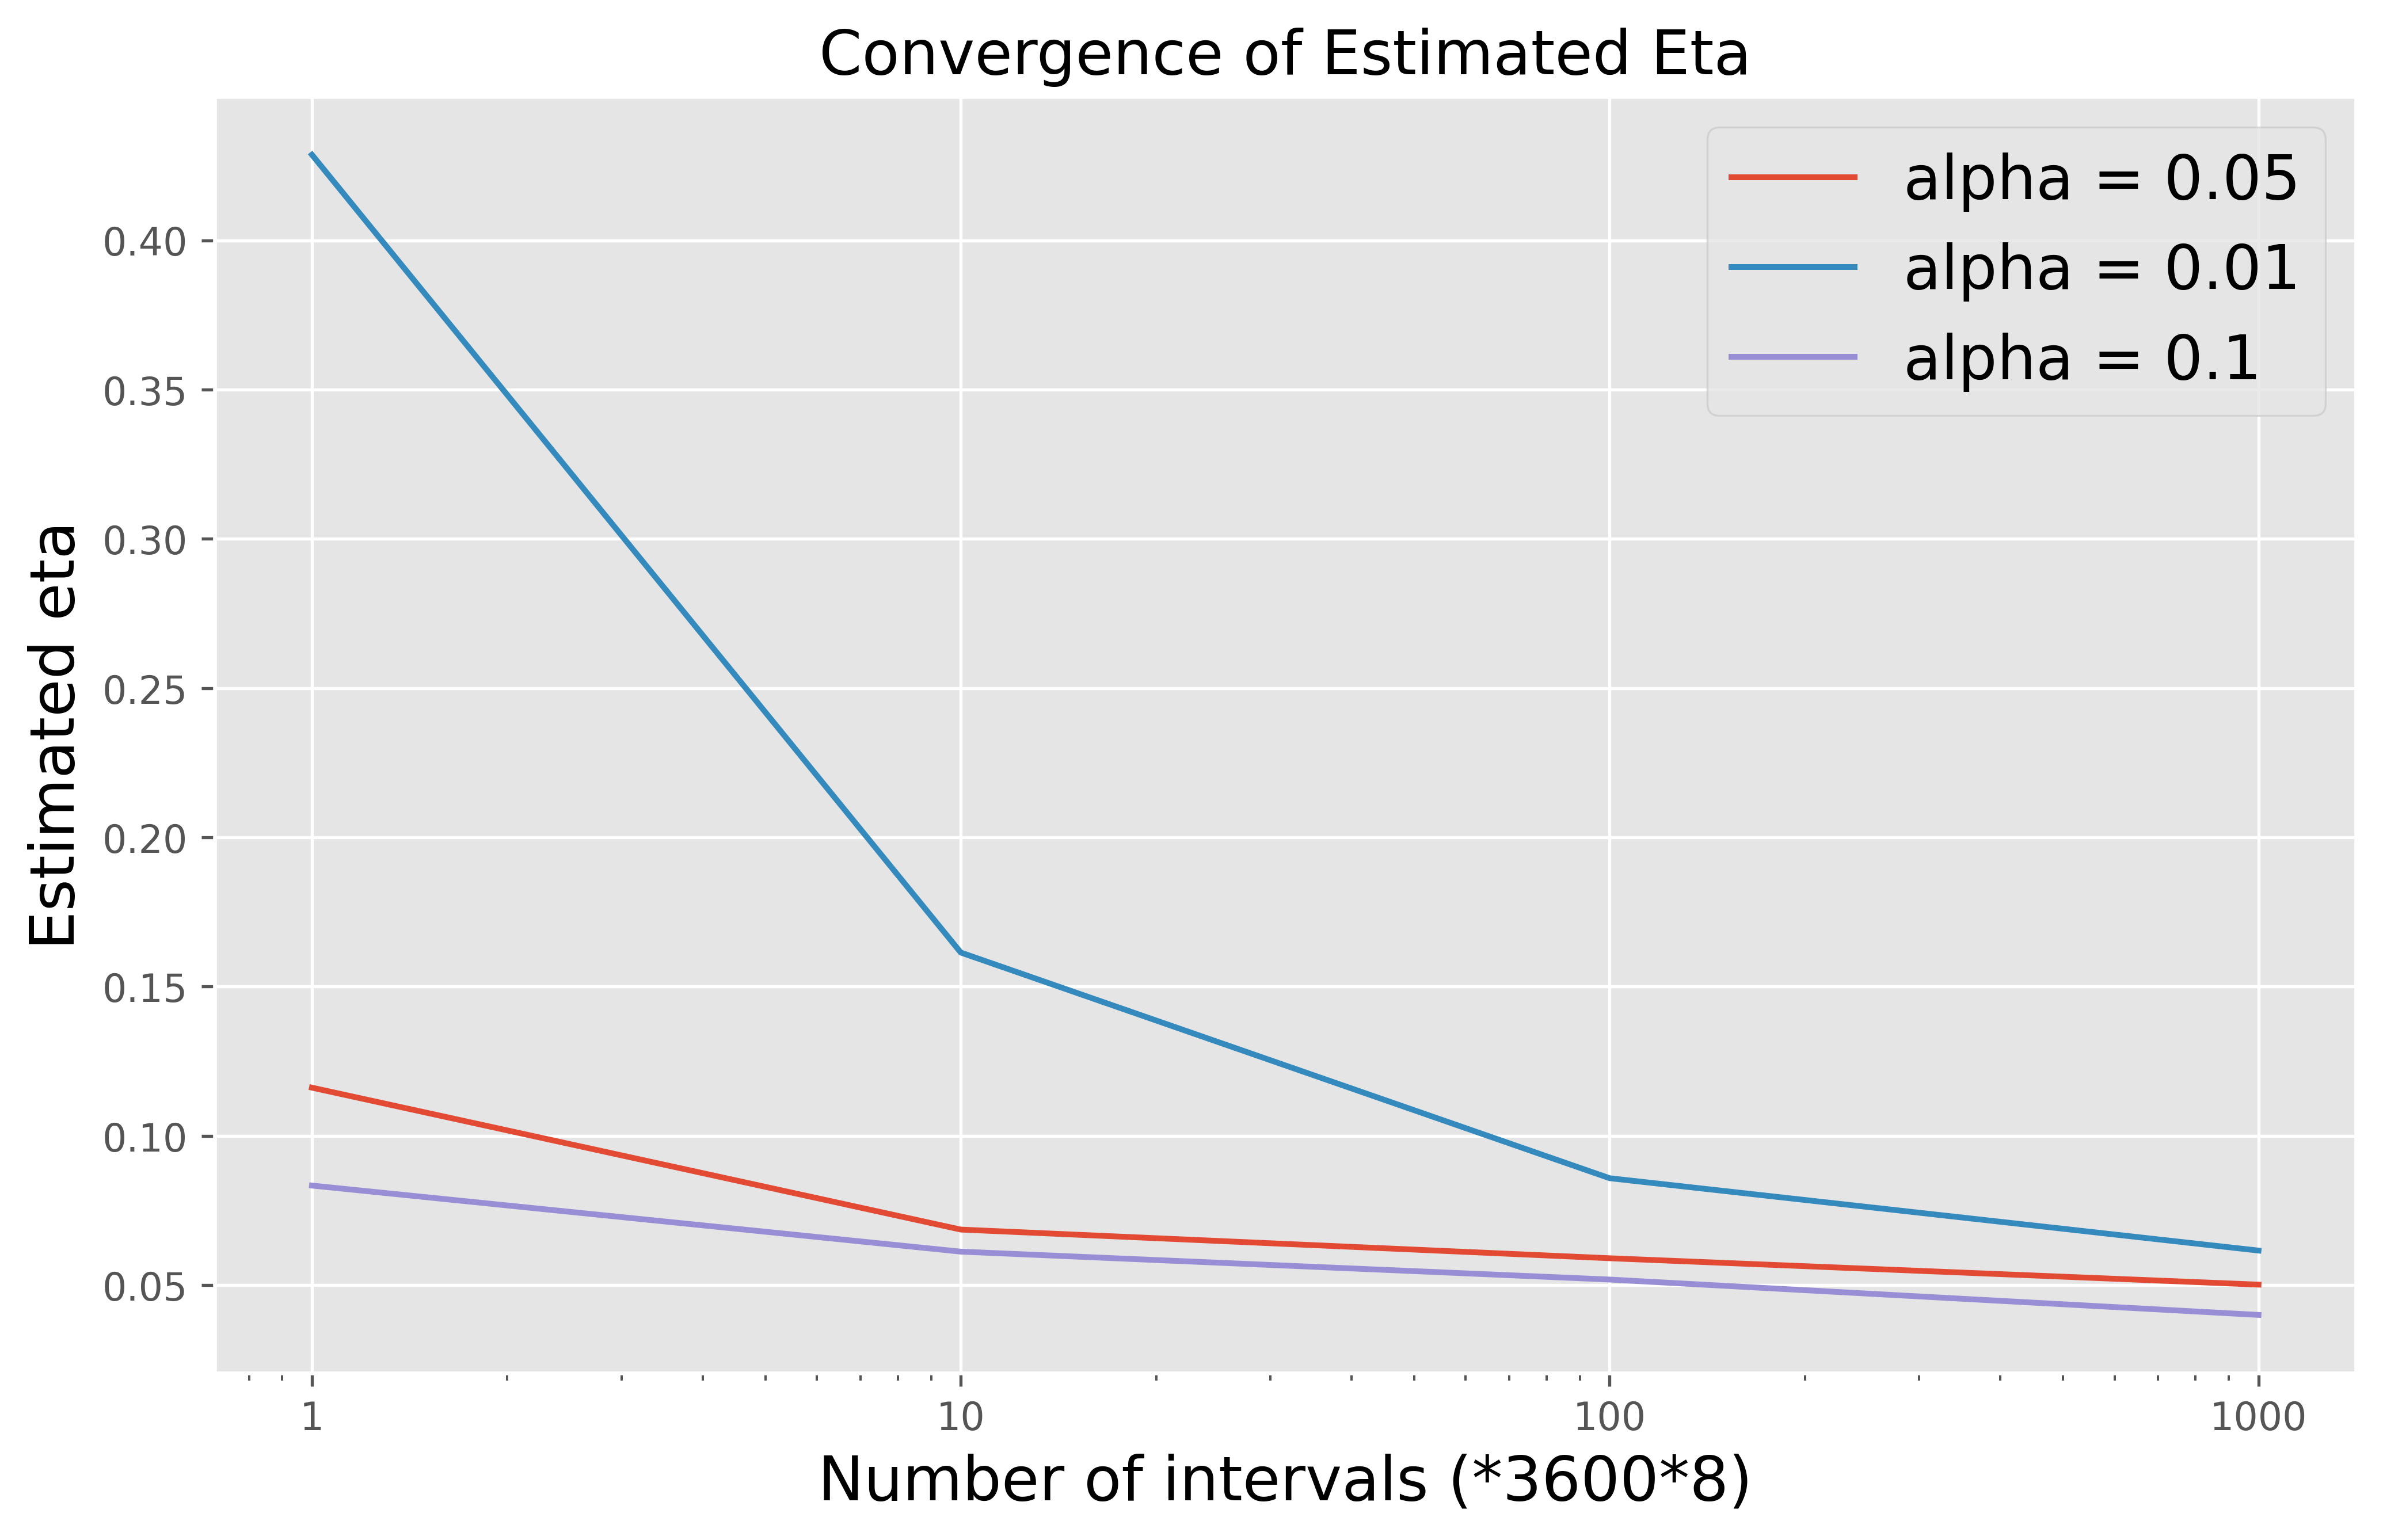

eta_hat for alpha = 0.01: [0.06155678]
eta_hat for alpha = 0.05: [0.05014577]
eta_hat for alpha = 0.1: [0.04]


In [7]:
# check estimated eta whether converges as the number of interval increases
eta_hat_list_005 = []
eta_hat_list_001 = []
eta_hat_list_01 = []
sequence = [10 ** i for i in range(4)]
for i in tqdm(sequence):
    eff = path(1,i*3600*8, seed = 50)

    # find eta_hat for alpha = 0.05,old_eta = 0.05
    P_1 = uncertainty_zone(eff, 0.05, 0.05, 1)[0]
    P_1 = filter_unchanged_prices(P_1)
    eta_hat_1 = compute_num_alter_conti(P_1, 0.05, 1)
    # eta_hat_1 = compute_num_alter_conti(P_1, 0.05, 5)
    # print('number of continuations:', eta_hat_1[0])
    # print('number of alternations:', eta_hat_1[1])

    # print("New eta estimate for alpha = 0.05:", 0.5 * (eta_hat_1[0]/eta_hat_1[1]))
    eta_hat_list_005.append(0.5 * (eta_hat_1[0]/eta_hat_1[1]))

    # find eta_hat for alpha = 0.01,old_eta = 0.05
    P_2 = uncertainty_zone(eff, 0.05, 0.01, 1)[0]
    P_2 = filter_unchanged_prices(P_2)
    eta_hat_2 = compute_num_alter_conti(P_2, 0.01, 1)
    # eta_hat_2 = compute_num_alter_conti(P_2, 0.01, 5)
    # print('number of continuations:', eta_hat_2[0])
    # print('number of alternations:', eta_hat_2[1])

    # print("New eta estimate for alpha = 0.01:", 0.5 * (eta_hat_2[0]/eta_hat_2[1]))
    eta_hat_list_001.append(0.5 * (eta_hat_2[0]/eta_hat_2[1]))

    # find eta_hat for alpha = 0.1,old_eta = 0.05
    P_3 = uncertainty_zone(eff, 0.05, 0.1, 1)[0]
    P_3 = filter_unchanged_prices(P_3)
    eta_hat_3 = compute_num_alter_conti(P_3, 0.1, 1)
    # print('number of continuations:', eta_hat_3[0])
    # print('number of alternations:', eta_hat_3[1])

    # print("New eta estimate for alpha = 0.1:", 0.5 * (eta_hat_3[0]/eta_hat_3[1]))
    eta_hat_list_01.append(0.5 * (eta_hat_3[0]/eta_hat_3[1]))


# plot the convergence of eta_hat
plt.plot(sequence, eta_hat_list_005, label='alpha = 0.05')
plt.plot(sequence, eta_hat_list_001, label='alpha = 0.01')
plt.plot(sequence, eta_hat_list_01, label='alpha = 0.1')
plt.xlabel('Number of intervals (*3600*8)', fontsize = 16)
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xticks(sequence, [str(val) for val in sequence])  # Set custom tick labels
plt.ylabel('Estimated eta', fontsize = 16)
plt.title('Convergence of Estimated Eta', fontsize = 16)
plt.legend(fontsize = 16)
plt.grid(True)
plt.savefig('Eta.eps', format='eps')
plt.show()
# print the last eta
print('eta_hat for alpha = 0.01:', eta_hat_list_001[-1])
print('eta_hat for alpha = 0.05:', eta_hat_list_005[-1])
print('eta_hat for alpha = 0.1:', eta_hat_list_01[-1])

So we will use 
- $\eta = 0.06$ for $α = 0.01$,
- $\eta = 0.05$ for $α = 0.05$(which showed the assumption in the numerical study is correct).
- $\eta = 0.04$ for $α = 0.1$.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


-0.024766155746266963


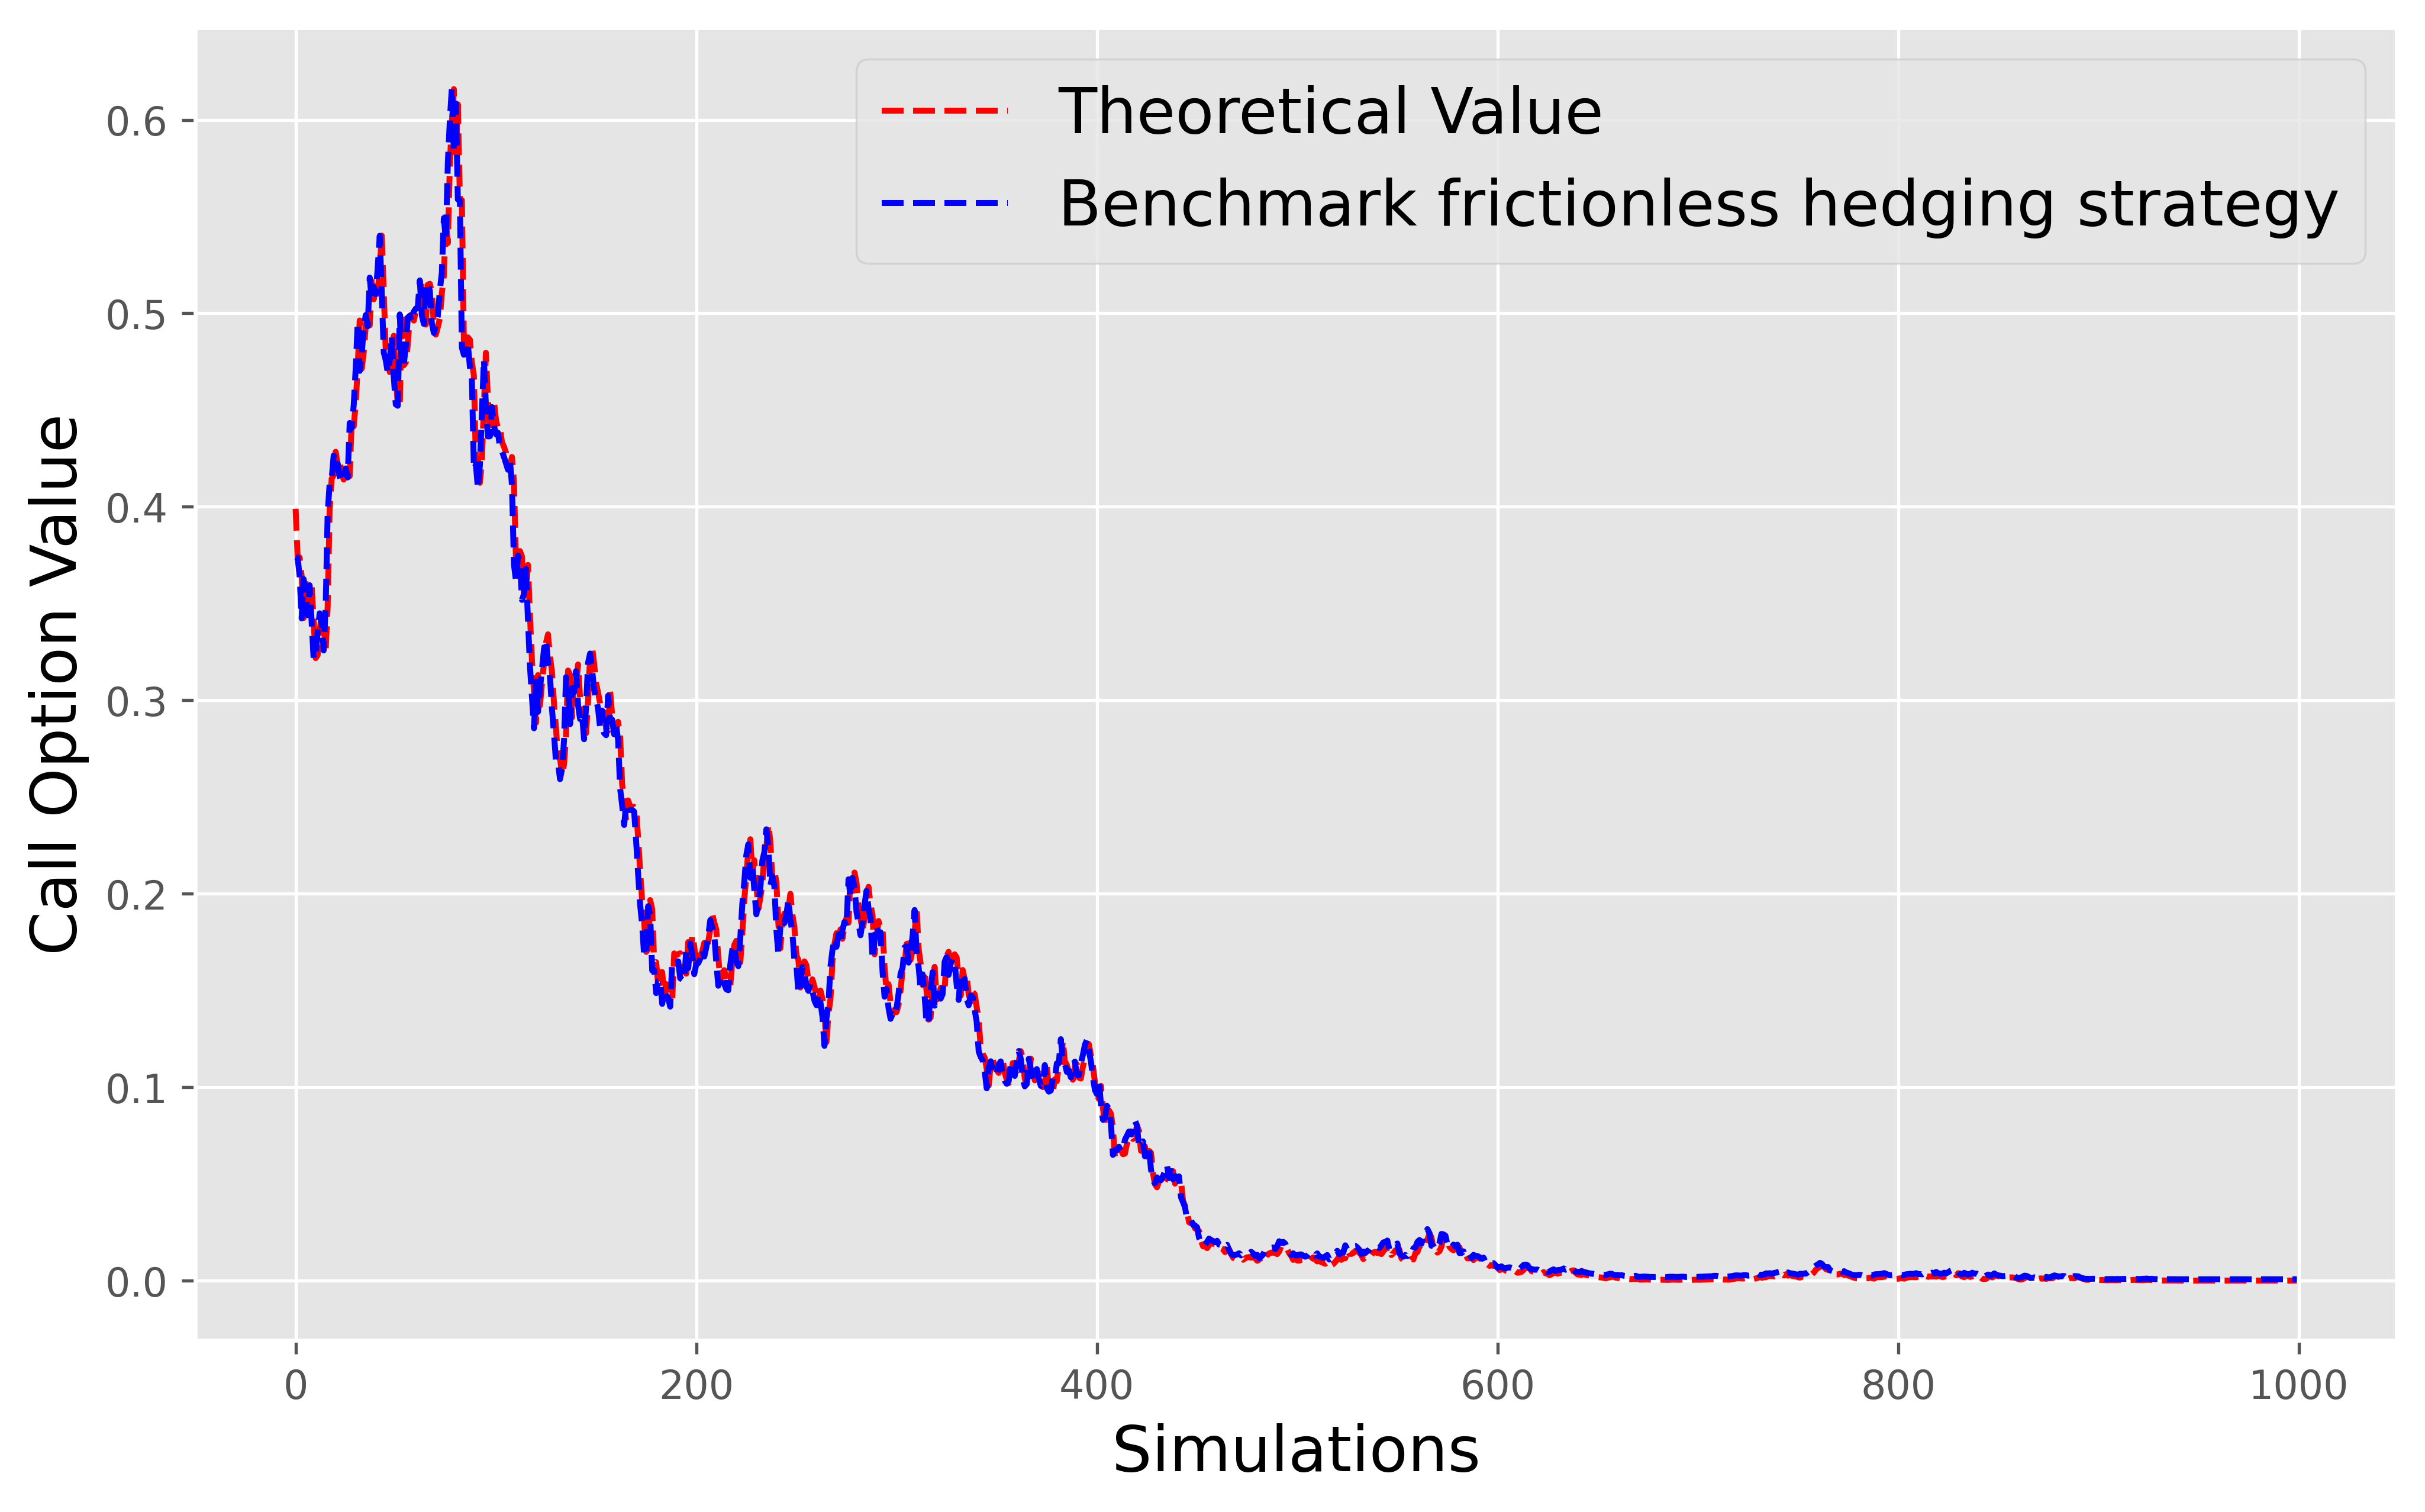

In [8]:
# function return BS call option price
def BS_price(price,t=0,strike_price=100,r=0,sigma=0.01,T=1):
    d_positive = (np.log(price/strike_price)+(r+0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t)+ 1e-9)
    d_negative = d_positive - sigma*np.sqrt(T-t)
    return price * norm.cdf(d_positive) - np.exp(-r*(T-t))*norm.cdf(d_negative)*strike_price

# calculate option value for different hedging strategies
def hedging():
    efficient_prices = path(1,1000,seed=50)
    t = np.linspace(0, 1, efficient_prices.shape[1])
    t = t.reshape(1, -1)
    delta_hedge_integral_eff = np.cumsum(
        C_derivative(efficient_prices[:, :-1],t=t[:,:-1]) *
        np.diff(efficient_prices, axis=1),
        axis=1)
    BS = BS_price(efficient_prices[:, :-1],t=t[:,:-1])
    BS0 = BS_price(100)
    plt.plot(BS.flatten(),"r--",label='Theoretical Value')
    plt.plot(BS0+delta_hedge_integral_eff.flatten(),"b--",label='Benchmark frictionless hedging strategy')
    plt.xlabel('Simulations', fontsize = 16)
    plt.ylabel('Call Option Value', fontsize = 16)
    plt.legend(fontsize = 16)
    plt.savefig('wrong.eps', format='eps')
    print(delta_hedge_integral_eff.flatten()[0])

hedging()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


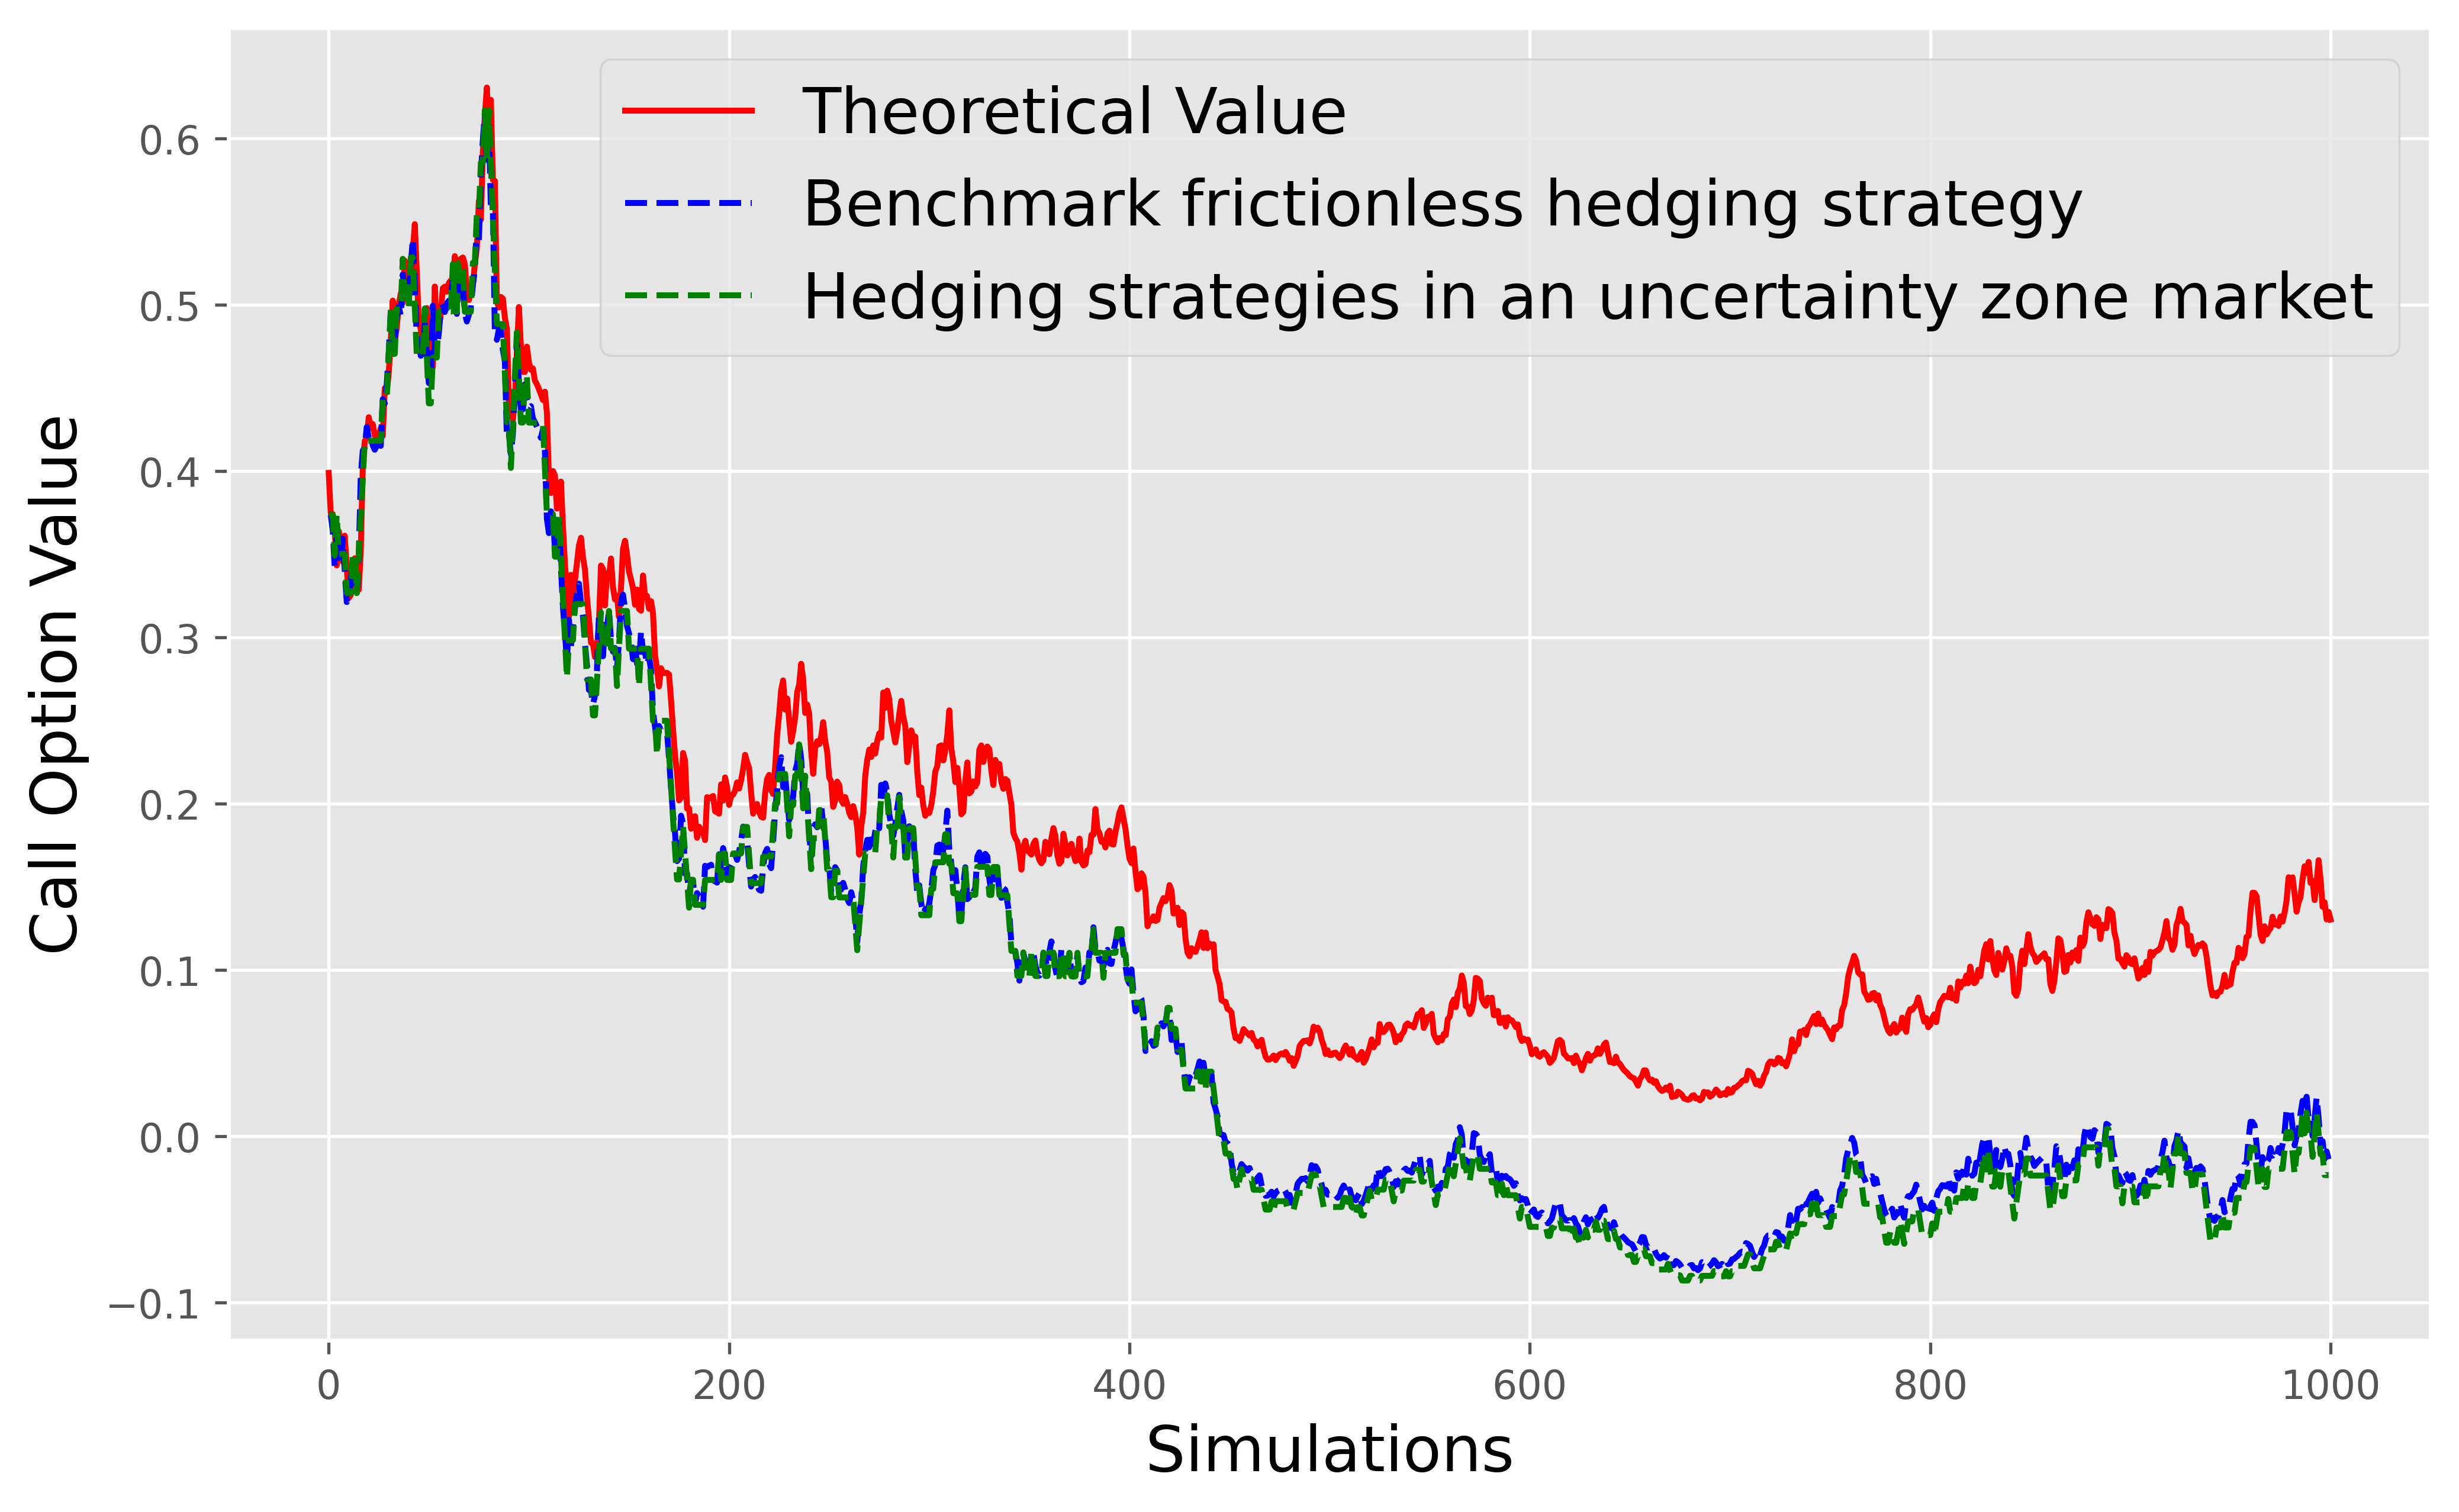

In [9]:
# calculate option value for different hedging strategies
def hedging():
    efficient_prices = path(1,1000,seed=50)
    ucm_prices, tau, x_tau, NR = uncertainty_zone(efficient_prices, eta=0.05, tick=0.05, num_of_tick=1)

    t = np.linspace(0, 1, efficient_prices.shape[1])
    t = t.reshape(1, -1)
    delta_hedge_integral_eff = np.cumsum(
        C_derivative(efficient_prices[:, :-1]) *
        np.diff(efficient_prices, axis=1),
        axis=1)
    phi_t = compute_matrix(t, tau)
    X_phi = compute_X_phi(phi_t, x_tau)
    delta_hedge_integral_ucm = np.cumsum(
        C_derivative(X_phi[:, :-1]) *
        np.diff(ucm_prices, axis=1),
        axis=1)
    BS = BS_price(efficient_prices)
    BS0 = BS_price(100)
    plt.plot(BS.flatten(),"r-",label='Theoretical Value')
    plt.plot((BS0 + delta_hedge_integral_eff.flatten()),"b--",label='Benchmark frictionless hedging strategy')
    plt.plot((BS0 + delta_hedge_integral_ucm.flatten()),"g--",label='Hedging strategies in an uncertainty zone market')
    plt.xlabel('Simulations', fontsize = 16)
    plt.ylabel('Call Option Value', fontsize = 16)
    plt.legend(fontsize = 16)
    plt.savefig('right.eps', format='eps')

hedging()

In [10]:
# functions to calculate the integrals
def L1(ucm_prices, efficient_prices, tau, x_tau):
    t = np.linspace(0, 1, efficient_prices.shape[1])
    t = t.reshape(1, -1)
    delta_hedge_integral_eff = np.cumsum(
        C_derivative(efficient_prices[:, :-1]) *
        np.diff(efficient_prices, axis=1),
        axis=1)
    phi_t = compute_matrix(t, tau)    
    X_phi = compute_X_phi(phi_t, x_tau)    
    delta_hedge_integral_ucm = np.cumsum(
        C_derivative(X_phi[:, :-1]) *
        np.diff(efficient_prices, axis=1),
        axis=1)
    return delta_hedge_integral_eff[:, -1] - delta_hedge_integral_ucm[:, -1]


def L23(ucm_prices, efficient_prices, tau, x_tau):
    t = np.linspace(0, 1, efficient_prices.shape[1])
    t = t.reshape(1, -1)
    delta_hedge_integral_eff = np.cumsum(
        C_derivative(efficient_prices[:, :-1]) *
        np.diff(efficient_prices, axis=1),
        axis=1)
    phi_t = compute_matrix(t, tau)
    X_phi = compute_X_phi(phi_t, x_tau)
    delta_hedge_integral_ucm = np.cumsum(
        C_derivative(X_phi[:, :-1]) *
        np.diff(ucm_prices, axis=1),
        axis=1)
    return delta_hedge_integral_eff[:, -1] - delta_hedge_integral_ucm[:, -1]

- For $\alpha = 0.01$, $l_\alpha = 0.01^{-\frac{1}{2}} = 10$. So we tried to rebalance the portfolio once the price moves by 10 ticks.
- For $\alpha = 0.05$, $l_\alpha = 0.05^{-\frac{1}{2}} = 4.47$. So we tried to rebalance the portfolio once the price moves by 4（Floor-Rounded Strategy） and 5（Ceiling-Rounded Strategy） ticks.
- For $\alpha = 0.1$, $l_\alpha = 0.1^{-\frac{1}{2}} = 3.16$. So we tried to rebalance the portfolio once the price moves by 3（Floor-Rounded Strategy） and 4（Ceiling-Rounded Strategy）ticks.

In [11]:
simu_num = 1000
L1_res_tick001 = [0]*simu_num
L2_res_tick001 = [0]*simu_num
L3_res_tick001_10 = [0]*simu_num

L1_res_tick005 = [0]*simu_num
L2_res_tick005 = [0]*simu_num
L3_res_tick005_5 = [0]*simu_num
L3_res_tick005_4 = [0]*simu_num

L1_res_tick01 = [0]*simu_num
L2_res_tick01 = [0]*simu_num
L3_res_tick01_4 = [0]*simu_num
L3_res_tick01_3 = [0]*simu_num

NR_12_mean_tick001 = [0]*simu_num
NR_3_mean_tick001_10 = [0]*simu_num

NR_12_mean_tick005 = [0]*simu_num
NR_3_mean_tick005_5 = [0]*simu_num
NR_3_mean_tick005_4 = [0]*simu_num

NR_12_mean_tick01 = [0]*simu_num
NR_3_mean_tick01_4 = [0]*simu_num
NR_3_mean_tick01_3 = [0]*simu_num

NR_12_std_tick001 = [0]*simu_num
NR_3_std_tick001_10 = [0]*simu_num

NR_12_std_tick005 = [0]*simu_num
NR_3_std_tick005_5 = [0]*simu_num
NR_3_std_tick005_4 = [0]*simu_num

NR_12_std_tick01 = [0]*simu_num
NR_3_std_tick01_4 = [0]*simu_num
NR_3_std_tick01_3 = [0]*simu_num
# calculate hedging error for 1000 Monte Carlo simulations
for i in tqdm(range(simu_num)):
    eff = path(1000,3600, seed = i)
    ucm_tick001, tau_tick001, x_tau_tick001, NR_12_count_tick001 = uncertainty_zone(eff, eta=0.06, tick=0.01, num_of_tick=1)
    ucm_tick005, tau_tick005, x_tau_tick005, NR_12_count_tick005 = uncertainty_zone(eff, eta=0.05, tick=0.05, num_of_tick=1)
    ucm_tick01, tau_tick01, x_tau_tick01, NR_12_count_tick01 = uncertainty_zone(eff, eta=0.04, tick=0.1, num_of_tick=1)
    ucm_tick001_10, tau_tick001_10, x_tau_tick001_10, NR_3_count_tick001_10 = uncertainty_zone(eff, eta=0.06, tick=0.01, num_of_tick=10)
    ucm_tick005_5, tau_tick005_5, x_tau_tick005_5, NR_3_count_tick005_5 = uncertainty_zone(eff, eta=0.05, tick=0.05, num_of_tick=5)
    ucm_tick005_4, tau_tick005_4, x_tau_tick005_4, NR_3_count_tick005_4 = uncertainty_zone(eff, eta=0.05, tick=0.05, num_of_tick=4)
    ucm_tick01_4, tau_tick01_4, x_tau_tick01_4, NR_3_count_tick01_4 = uncertainty_zone(eff, eta=0.04, tick=0.1, num_of_tick=4)
    ucm_tick01_3, tau_tick01_3, x_tau_tick01_3, NR_3_count_tick01_3 = uncertainty_zone(eff, eta=0.04, tick=0.1, num_of_tick=3)

    NR_12_mean_tick001[i] = NR_12_count_tick001.mean()
    NR_3_mean_tick001_10[i] = NR_3_count_tick001_10.mean()
    
    NR_12_mean_tick005[i] = NR_12_count_tick005.mean()
    NR_3_mean_tick005_5[i] = NR_3_count_tick005_5.mean()
    NR_3_mean_tick005_4[i] = NR_3_count_tick005_4.mean()
    
    NR_12_mean_tick01[i] = NR_12_count_tick01.mean()
    NR_3_mean_tick01_4[i] = NR_3_count_tick01_4.mean()
    NR_3_mean_tick01_3[i] = NR_3_count_tick01_3.mean()
    
    NR_12_std_tick001[i] = NR_12_count_tick001.std()
    NR_3_std_tick001_10[i] = NR_3_count_tick001_10.std()
    
    NR_12_std_tick005[i] = NR_12_count_tick005.std()
    NR_3_std_tick005_5[i] = NR_3_count_tick005_5.std()
    NR_3_std_tick005_4[i] = NR_3_count_tick005_4.std()
    
    NR_12_std_tick01[i] = NR_12_count_tick01.std()
    NR_3_std_tick01_4[i] = NR_3_count_tick01_4.std()
    NR_3_std_tick01_3[i] = NR_3_count_tick01_3.std()
    
    L1_res_tick001[i] = L1(ucm_tick001, eff, tau_tick001, x_tau_tick001).mean()
    L2_res_tick001[i] = L23(ucm_tick001, eff, tau_tick001, x_tau_tick001).mean()
    L3_res_tick001_10[i] = L23(ucm_tick001_10, eff, tau_tick001_10, x_tau_tick001_10).mean()
    
    L1_res_tick005[i] = L1(ucm_tick005, eff, tau_tick005, x_tau_tick005).mean()
    L2_res_tick005[i] = L23(ucm_tick005, eff, tau_tick005, x_tau_tick005).mean()
    L3_res_tick005_5[i] = L23(ucm_tick005_5, eff, tau_tick005_5, x_tau_tick005_5).mean()
    L3_res_tick005_4[i] = L23(ucm_tick005_4, eff, tau_tick005_4, x_tau_tick005_4).mean()
    
    L1_res_tick01[i] = L1(ucm_tick01, eff, tau_tick01, x_tau_tick01).mean()
    L2_res_tick01[i] = L23(ucm_tick01, eff, tau_tick01, x_tau_tick01).mean()
    L3_res_tick01_4[i] = L23(ucm_tick01_4, eff, tau_tick01_4, x_tau_tick01_4).mean()
    L3_res_tick01_3[i] = L23(ucm_tick01_3, eff, tau_tick01_3, x_tau_tick01_3).mean()
    
    

100%|██████████| 1000/1000 [1:26:19<00:00,  5.18s/it]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


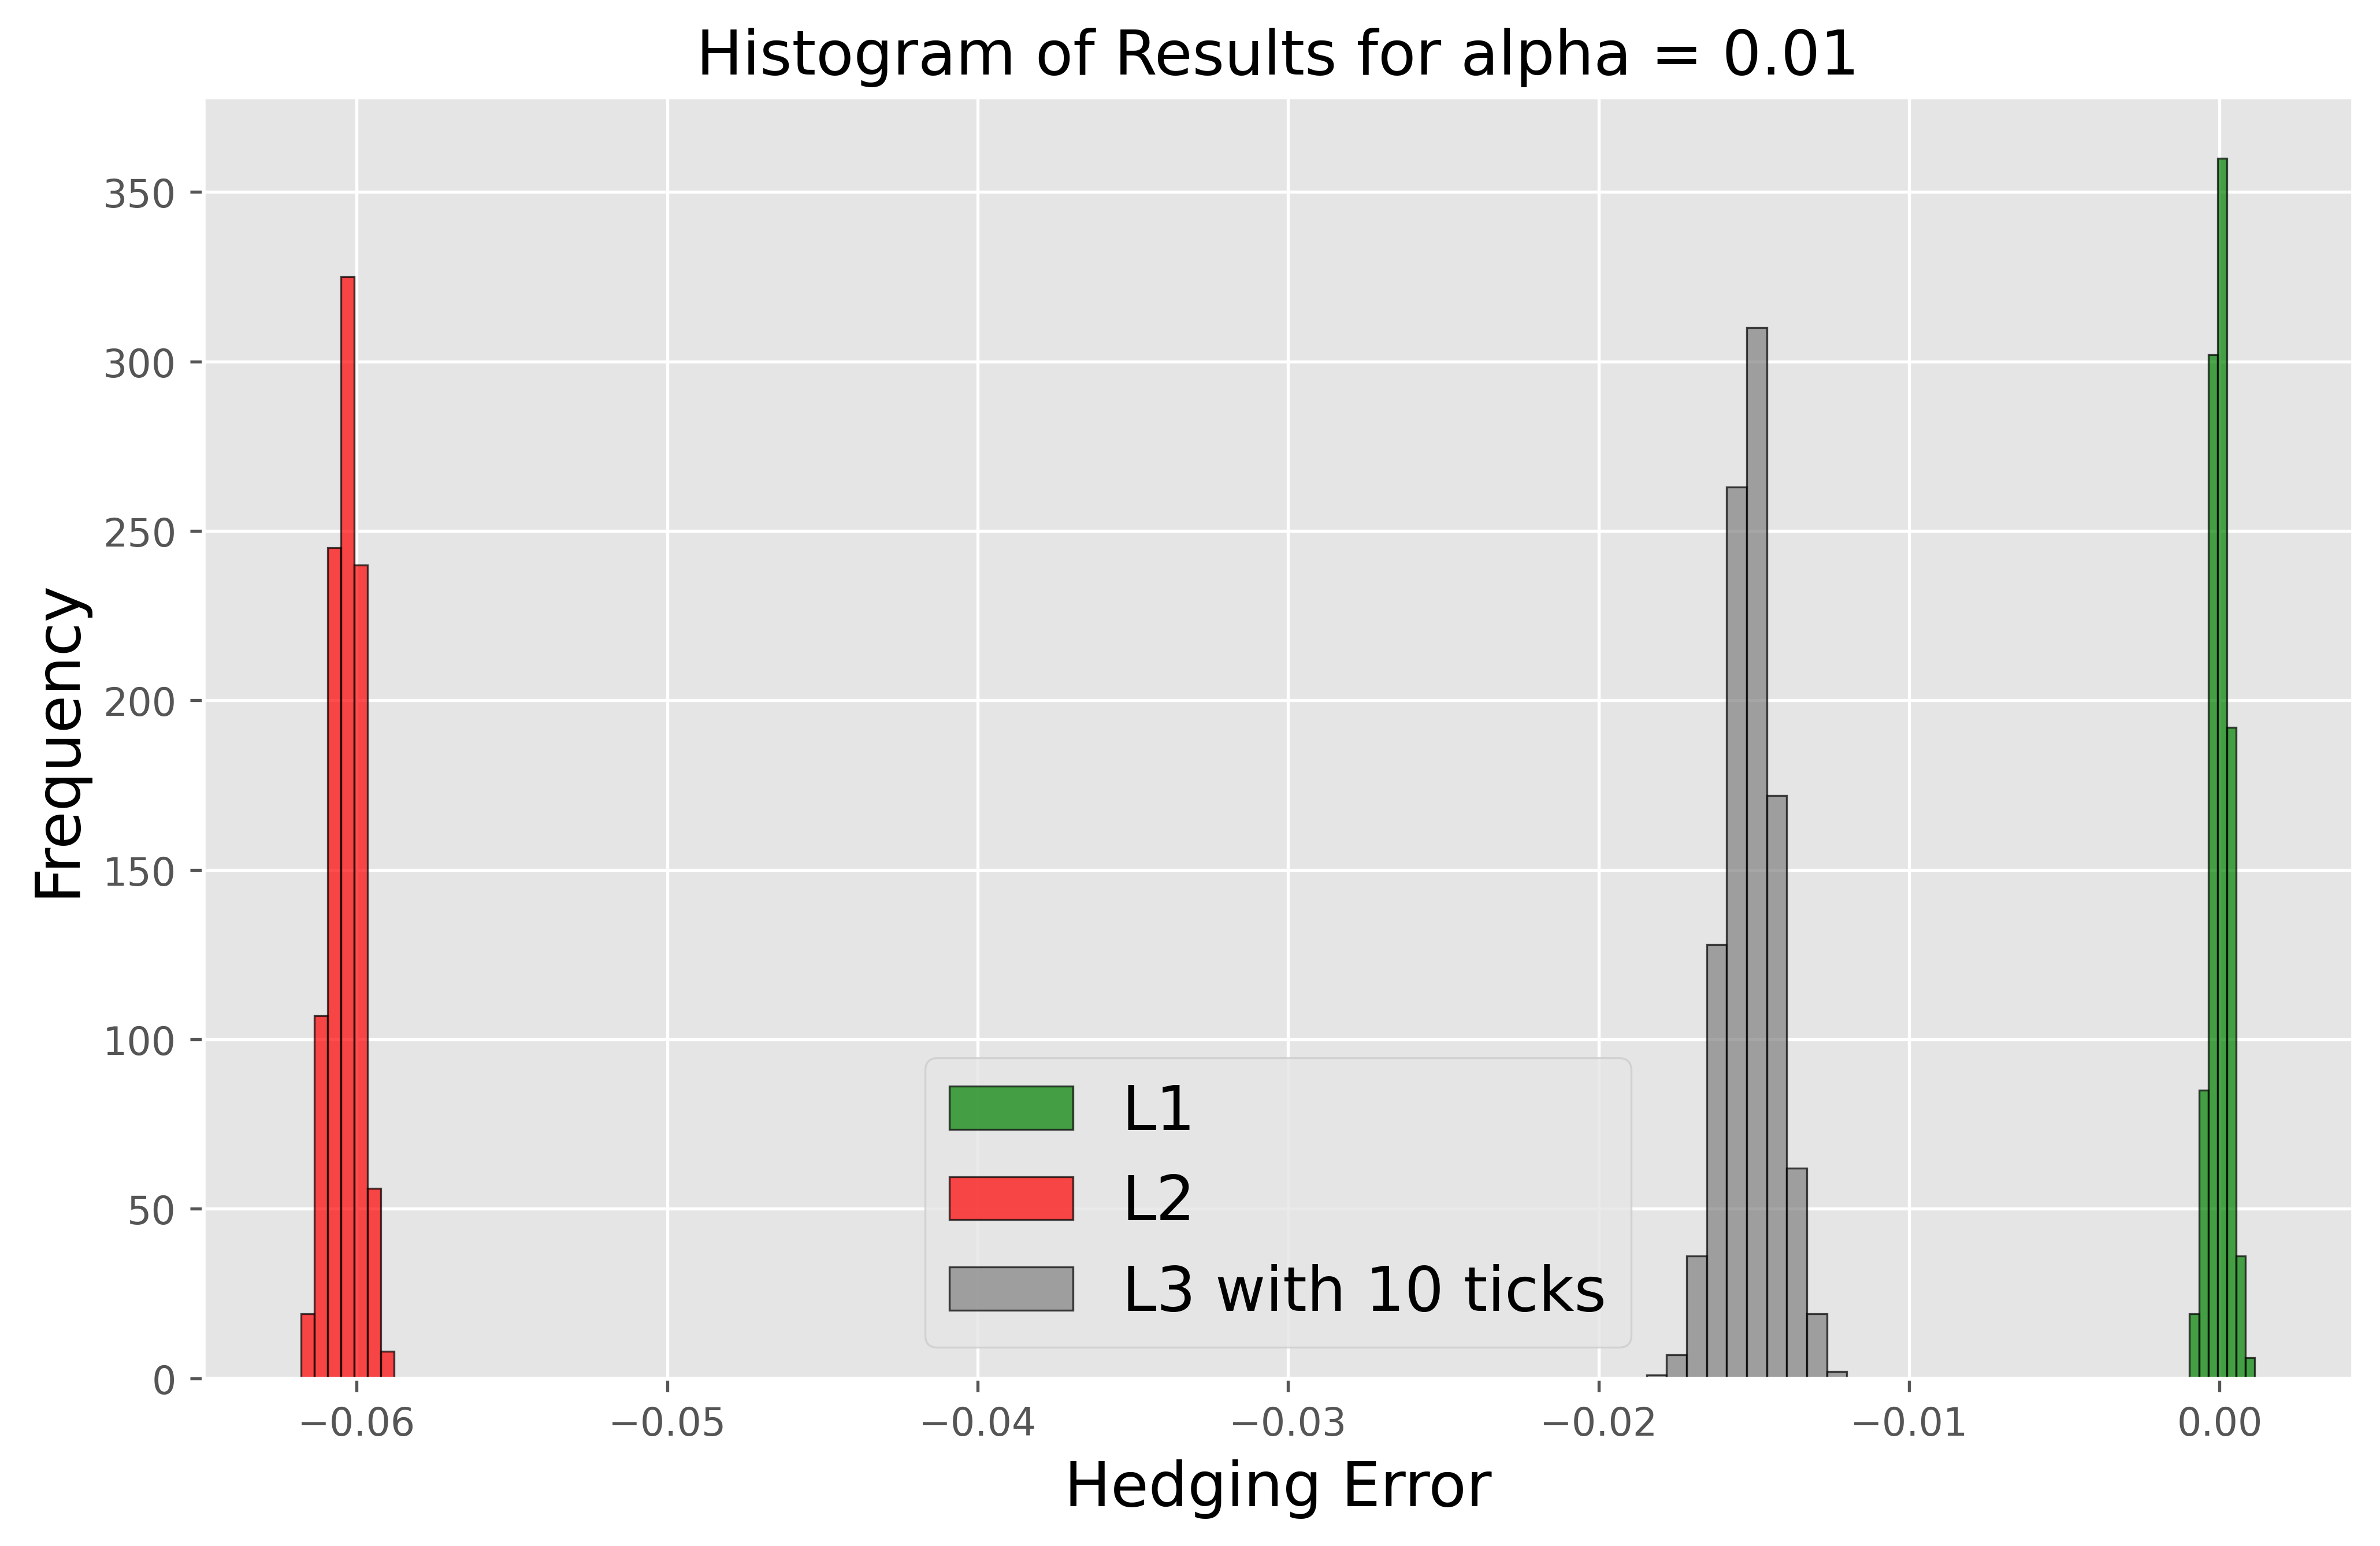

Average of NR - Every price move rebalancing: 2860.7709059999997
Average of NR - 10 ticks rebalancing: 90.255754
Standard deviation of NR - Every price move rebalancing: 28.355424738992244
Standard deviation of NR - 10 ticks rebalancing: 7.823850472373163


In [12]:
# alpha = 0.01
plt.hist(L1_res_tick001, bins=7, label='L1', color='g', edgecolor='black', alpha=0.7)
plt.hist(L2_res_tick001, bins=7, label='L2', color='r', edgecolor='black', alpha=0.7)
plt.hist(L3_res_tick001_10, bins=10, label='L3 with 10 ticks', color='grey', edgecolor='black', alpha=0.7)
plt.xlabel('Hedging Error', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Histogram of Results for alpha = 0.01', fontsize = 16)
plt.legend(fontsize = 16)
plt.grid(True)
# Save the plot as an EPS file
plt.savefig('Hist001.eps', format='eps')
plt.show()


print("Average of NR - Every price move rebalancing:", np.mean(NR_12_mean_tick001))
print("Average of NR - 10 ticks rebalancing:", np.mean(NR_3_mean_tick001_10))
print("Standard deviation of NR - Every price move rebalancing:", np.mean(NR_12_std_tick001))
print("Standard deviation of NR - 10 ticks rebalancing:", np.mean(NR_3_std_tick001_10))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


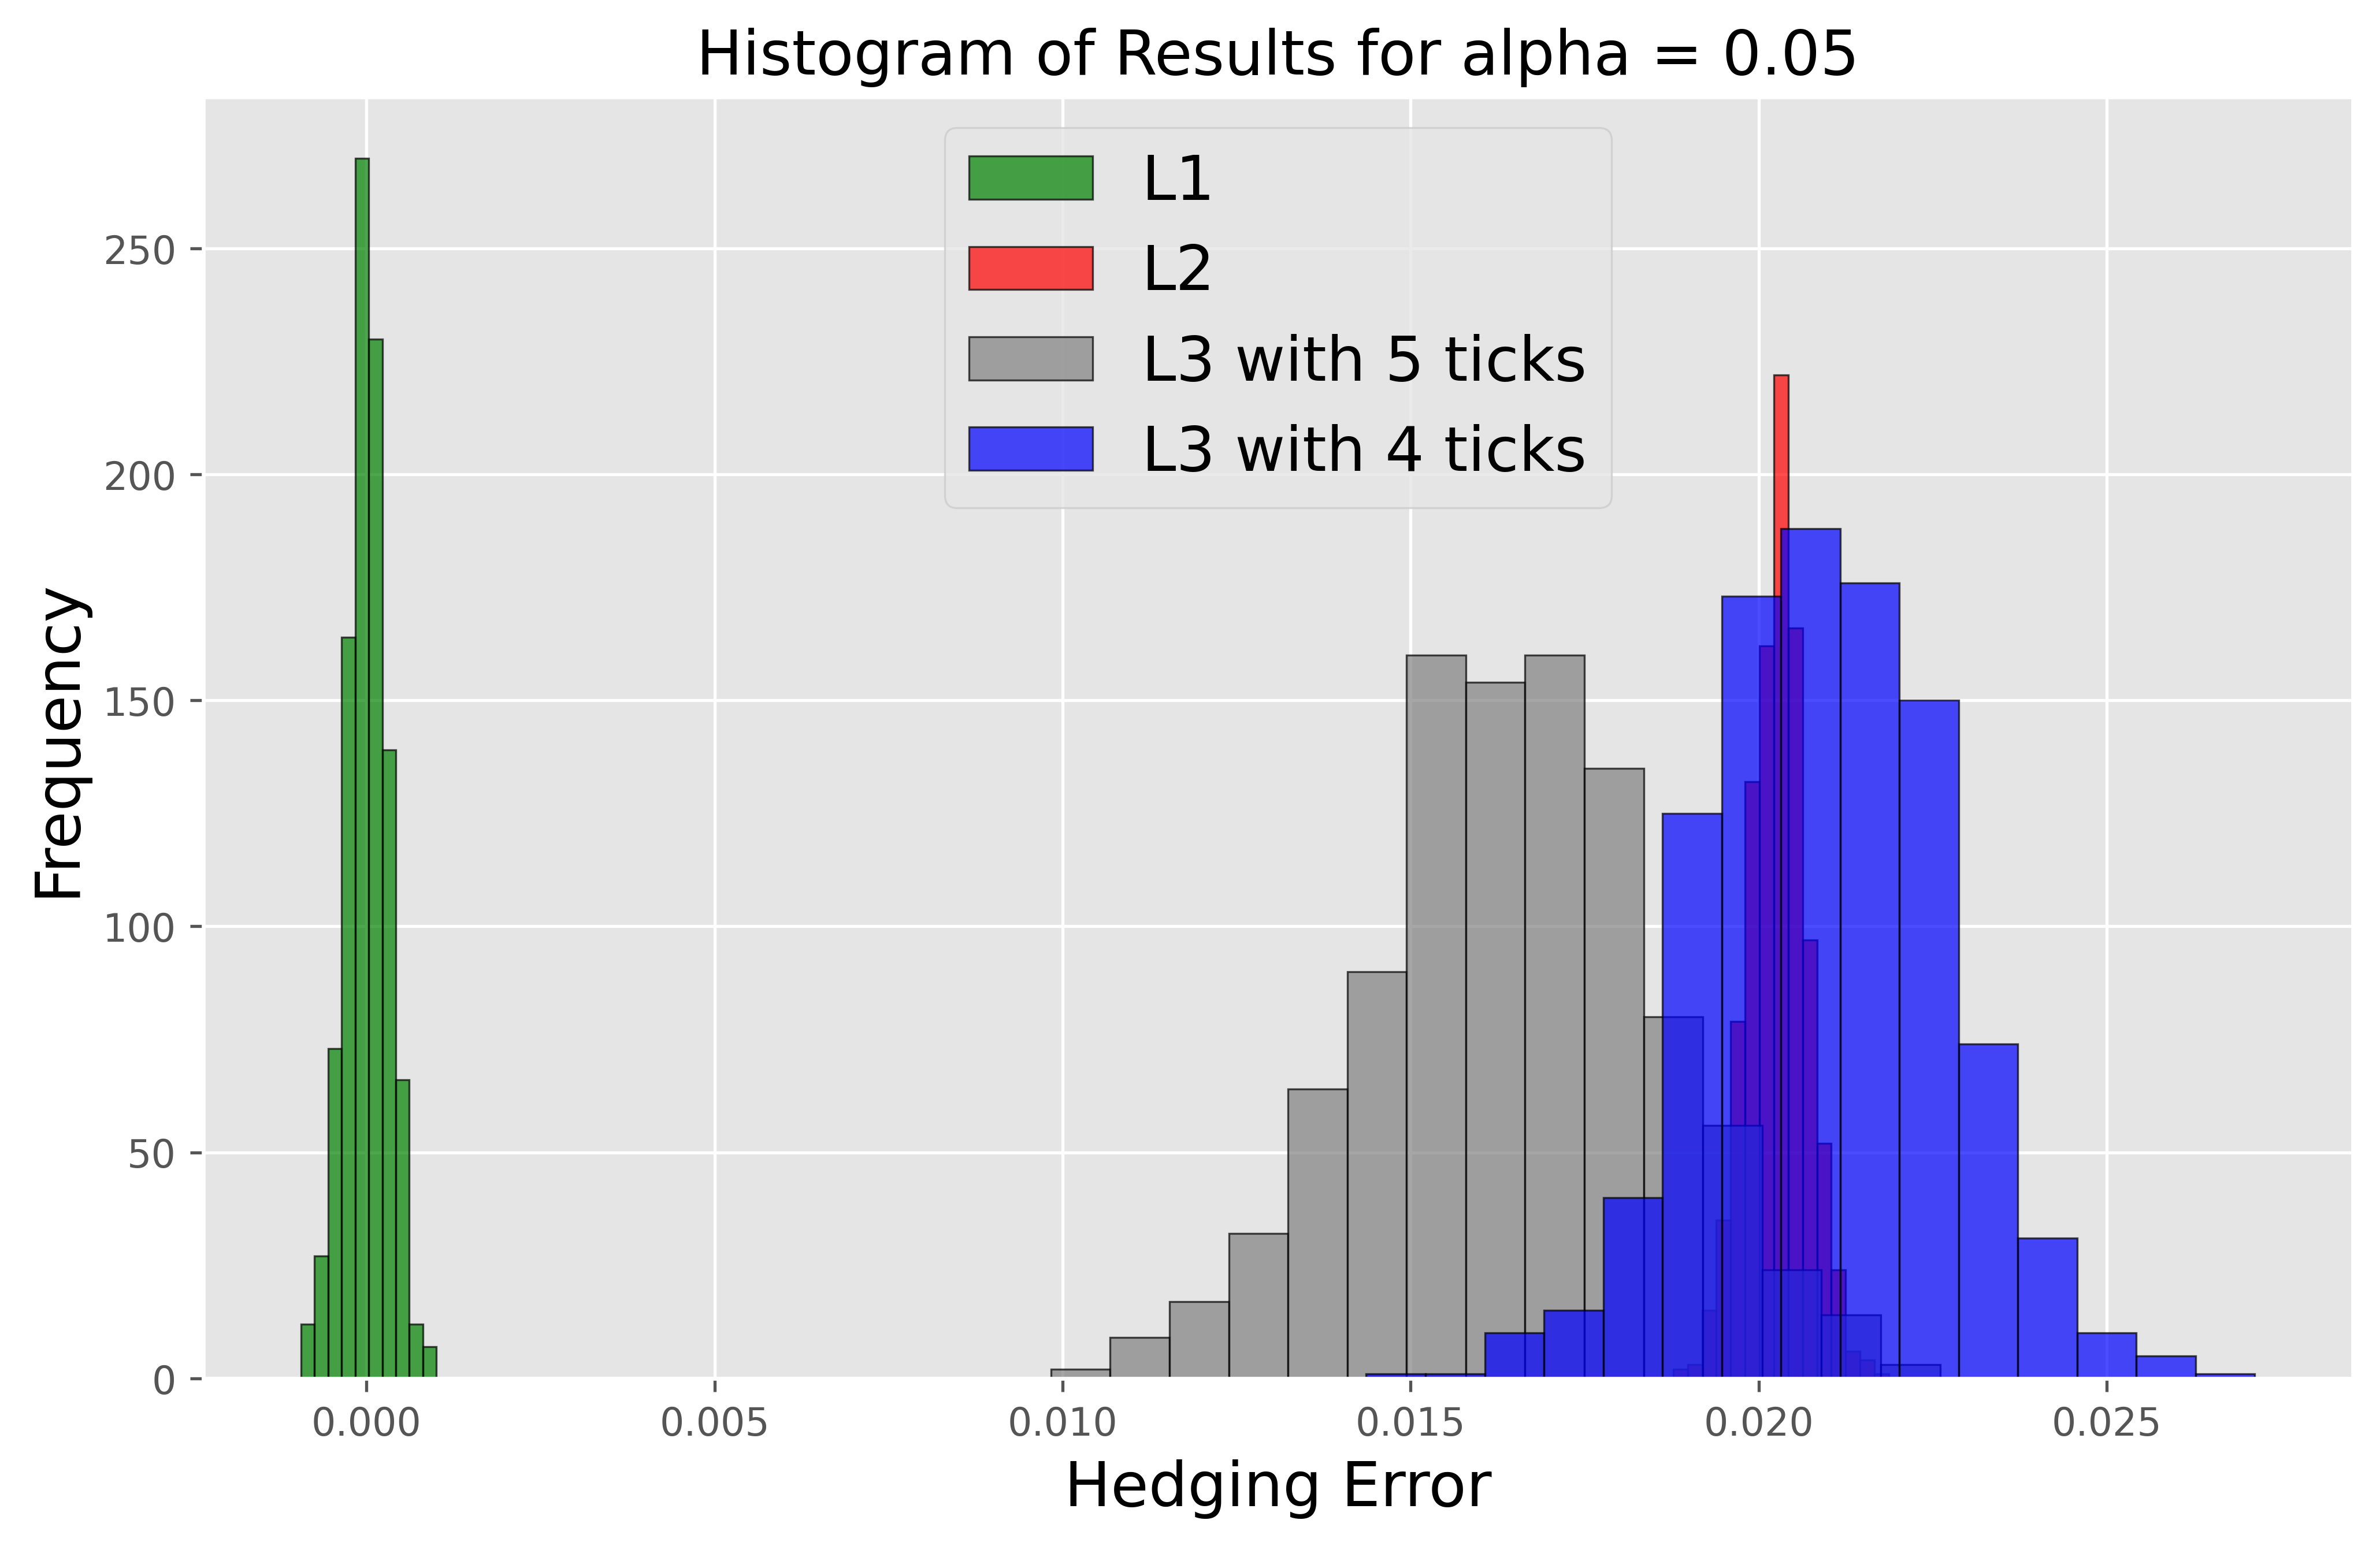

Average of NR - Every price move rebalancing: 797.474685
Average of NR - 5 ticks rebalancing: 17.657256
Average of NR - 4 ticks rebalancing: 28.505181
Standard deviation of NR - Every price move rebalancing: 25.82922077910088
Standard deviation of NR - 5 ticks rebalancing: 3.4503069182444186
Standard deviation of NR - 4 ticks rebalancing: 4.391762530703575


In [13]:
# alpha = 0.05
plt.hist(L1_res_tick005, bins=10, label='L1', color='g', edgecolor='black', alpha=0.7)
plt.hist(L2_res_tick005, bins=15, label='L2', color='r', edgecolor='black', alpha=0.7)
plt.hist(L3_res_tick005_5, bins=15, label='L3 with 5 ticks', color='grey', edgecolor='black', alpha=0.7)
plt.hist(L3_res_tick005_4, bins=15, label='L3 with 4 ticks', color='b', edgecolor='black', alpha=0.7)
plt.xlabel('Hedging Error', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Histogram of Results for alpha = 0.05', fontsize = 16)
plt.legend(fontsize = 16)
plt.grid(True)
# Save the plot as an EPS file
plt.savefig('Hist005.eps', format='eps')
plt.show()

print("Average of NR - Every price move rebalancing:", np.mean(NR_12_mean_tick005))
print("Average of NR - 5 ticks rebalancing:", np.mean(NR_3_mean_tick005_5))
print("Average of NR - 4 ticks rebalancing:", np.mean(NR_3_mean_tick005_4))
print("Standard deviation of NR - Every price move rebalancing:", np.mean(NR_12_std_tick005))
print("Standard deviation of NR - 5 ticks rebalancing:", np.mean(NR_3_std_tick005_5))
print("Standard deviation of NR - 4 ticks rebalancing:", np.mean(NR_3_std_tick005_4))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


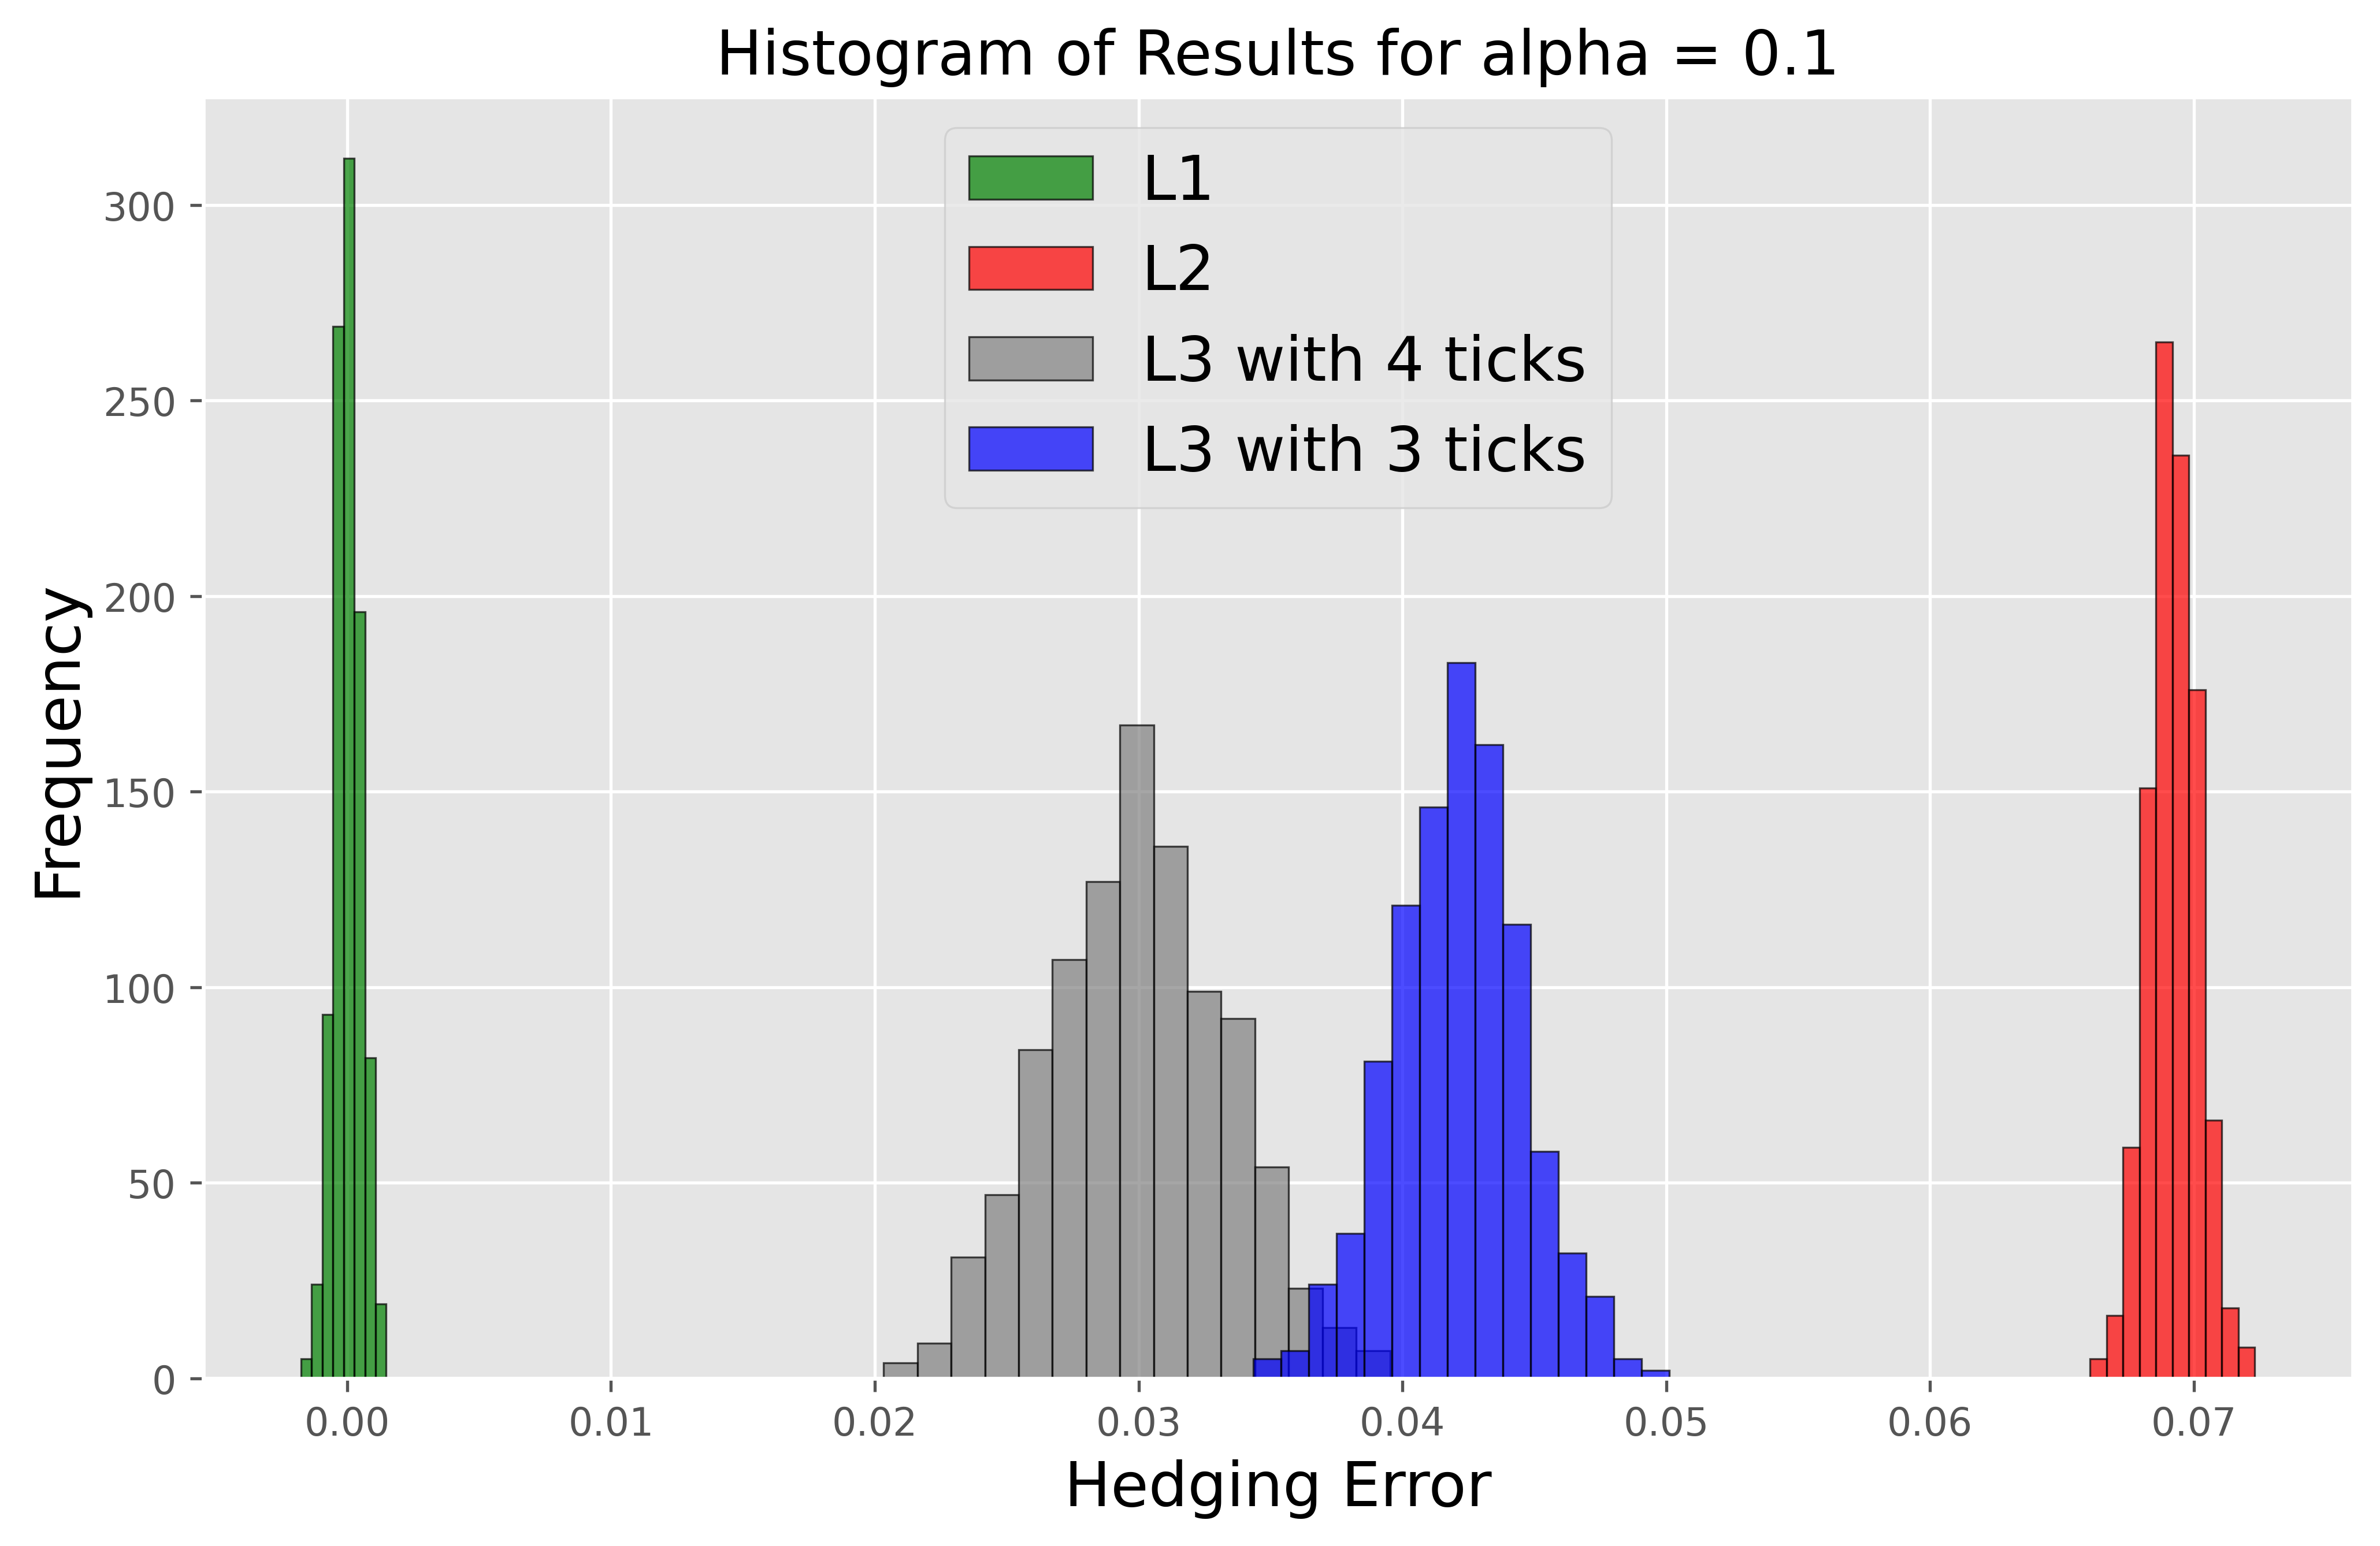

Average of NR - Every price move rebalancing: 359.871421
Average of NR - 4 ticks rebalancing: 7.467484
Average of NR - 3 ticks rebalancing: 14.483108
Standard deviation of NR - Every price move rebalancing: 21.58928130078825
Standard deviation of NR - 4 ticks rebalancing: 2.261480643933367
Standard deviation of NR - 3 ticks rebalancing: 3.174746335406716


In [14]:
# alpha = 0.1
plt.hist(L1_res_tick01, bins=8, label='L1', color='g', edgecolor='black', alpha=0.7)
plt.hist(L2_res_tick01, bins=10, label='L2', color='r', edgecolor='black', alpha=0.7)
plt.hist(L3_res_tick01_4, bins=15, label='L3 with 4 ticks', color='grey', edgecolor='black', alpha=0.7)
plt.hist(L3_res_tick01_3, bins=15, label='L3 with 3 ticks', color='b', edgecolor='black', alpha=0.7)
plt.xlabel('Hedging Error', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Histogram of Results for alpha = 0.1', fontsize = 16)
plt.legend(fontsize = 16)
plt.grid(True)
# Save the plot as an EPS file
plt.savefig('Hist01.eps', format='eps')
plt.show()

print("Average of NR - Every price move rebalancing:", np.mean(NR_12_mean_tick01))
print("Average of NR - 4 ticks rebalancing:", np.mean(NR_3_mean_tick01_4))
print("Average of NR - 3 ticks rebalancing:", np.mean(NR_3_mean_tick01_3))
print("Standard deviation of NR - Every price move rebalancing:", np.mean(NR_12_std_tick01))
print("Standard deviation of NR - 4 ticks rebalancing:", np.mean(NR_3_std_tick01_4))
print("Standard deviation of NR - 3 ticks rebalancing:", np.mean(NR_3_std_tick01_3))
